In [9]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

from src.data.load_data import load_raw_data
from src.data.data_profiler import check_data
import polars as pl

df_JFM = load_raw_data(year=2020, quarter=1)
df_April = load_raw_data(year=2020, month=4)
df_May = load_raw_data(year=2020, month=5)
df_June  = load_raw_data(year=2020, month=6)
df_July = load_raw_data(year=2020, month=7)
df_August = load_raw_data(year=2020, month=8)
df_September  = load_raw_data(year=2020, month=9)
df_October  = load_raw_data(year=2020, month=10)
df_November = load_raw_data(year=2020, month=11)
df_December = load_raw_data(year=2020, month=12)

In [10]:
import sys
from pathlib import Path
import traceback
sys.path.insert(0, str(Path.cwd().parent))

from src.data.load_data import load_raw_data
import polars as pl

def load_year_data_detailed(year):
    """Загрузка данных за год с детальной диагностикой"""
    dataframes = []
    errors = []
    
    # Словарь для загрузки по месяцам
    month_loads = [
        ("Q1 (Янв-Март)", {'quarter': 1}),
        ("Апрель", {'month': 4}),
        ("Май", {'month': 5}),
        ("Июнь", {'month': 6}),
        ("Июль", {'month': 7}),
        ("Август", {'month': 8}),
        ("Сентябрь", {'month': 9}),
        ("Октябрь", {'month': 10}),
        ("Ноябрь", {'month': 11}),
        ("Декабрь", {'month': 12})
    ]
    
    for label, params in month_loads:
        try:
            df = load_raw_data(year=year, **params)
            if df is not None and df.height > 0:
                dataframes.append(df)
                print(f"✓ {year} {label}: {df.height} строк")
            else:
                errors.append(f"{year} {label}: пустой датафрейм")
        except Exception as e:
            error_msg = f"{year} {label}: {str(e)[:100]}"
            errors.append(error_msg)
    
    # Объединение данных
    if dataframes:
        # Проверка совместимости схем
        first_schema = dataframes[0].schema
        for i, df in enumerate(dataframes[1:], 1):
            if df.schema != first_schema:
                print(f"⚠ Разные схемы в {year}, датафрейм {i}:")
                for col in df.schema:
                    if col in first_schema and df.schema[col] != first_schema[col]:
                        print(f"  Колонка '{col}': {first_schema[col]} != {df.schema[col]}")
        
        # Используем vertical_relaxed для объединения датафреймов с разными типами
        try:
            df_year = pl.concat(dataframes, how="vertical_relaxed")
        except:
            # Если vertical_relaxed не поддерживается, пробуем привести типы вручную
            print(f"  Используем ручное приведение типов...")
            # Определяем общую схему (используем String для спорных типов)
            common_schema = {}
            for df in dataframes:
                for col in df.columns:
                    if col not in common_schema:
                        common_schema[col] = df.schema[col]
                    elif common_schema[col] != df.schema[col]:
                        # Если типы различаются, приводим к String
                        common_schema[col] = pl.String
            
            # Приводим все датафреймы к общей схеме
            aligned_dataframes = []
            for df in dataframes:
                df_aligned = df.clone()
                for col, dtype in common_schema.items():
                    if col in df_aligned.columns and df_aligned.schema[col] != dtype:
                        df_aligned = df_aligned.with_columns(pl.col(col).cast(dtype))
                aligned_dataframes.append(df_aligned)
            
            df_year = pl.concat(aligned_dataframes, how="vertical")
        
        # Добавляем столбец с годом если его нет
        if 'year' not in df_year.columns:
            df_year = df_year.with_columns(pl.lit(year).alias('year'))
        
        # Сортировка по дате если есть временной столбец
        time_columns = ['date', 'timestamp', 'time', 'datetime', 'started_at', 'ended_at']
        for time_col in time_columns:
            if time_col in df_year.columns:
                df_year = df_year.sort(time_col)
                print(f"  Отсортировано по {time_col}")
                break
        
        return df_year, errors
    else:
        return None, errors

# Основной процесс загрузки
print("="*60)
print("ЗАГРУЗКА ДАННЫХ ЗА 2020-2025 ГОДЫ")
print("="*60)

all_data = {}
all_errors = {}

for year in range(2020, 2026):
    print(f"\nЗагрузка {year} года...")
    df_year, errors = load_year_data_detailed(year)
    
    if df_year is not None:
        all_data[year] = df_year
        all_errors[year] = errors
        globals()[f"df_{year}"] = df_year
        print(f"✓ {year}: {df_year.height} строк, {len(df_year.columns)} колонок")
        
        # Быстрая проверка данных
        print(f"  Столбцы: {list(df_year.columns)}")
        
        # Проверка диапазона дат
        date_cols = [c for c in df_year.columns if 'date' in c.lower() or 'time' in c.lower()]
        if date_cols:
            try:
                min_date = df_year[date_cols[0]].min()
                max_date = df_year[date_cols[0]].max()
                print(f"  Диапазон дат: {min_date} - {max_date}")
            except:
                print("  Диапазон дат: не определен")
        
        # Проверка пропусков - ИСПРАВЛЕННАЯ ЧАСТЬ
        null_counts = df_year.null_count()
        print("  Пропуски по столбцам:")
        total_nulls = 0
        for col in df_year.columns:
            nulls = null_counts[col][0]  # Получаем значение как число
            total_nulls += nulls
            if nulls > 0:
                pct = (nulls / df_year.height) * 100
                print(f"    {col}: {nulls} ({pct:.1f}%)")
        print(f"  Всего пропусков: {total_nulls}")
        
    else:
        all_errors[year] = errors
        print(f"✗ {year}: данные не загружены")
    
    if errors:
        print(f"  Ошибок загрузки: {len(errors)}")
        for err in errors[:3]:
            print(f"    - {err}")
        if len(errors) > 3:
            print(f"    ... и еще {len(errors) - 3} ошибок")

# Создание общего датафрейма
print("\n" + "="*60)
print("СОЗДАНИЕ ОБЩЕГО ДАТАФРЕЙМА")
print("="*60)

if all_data:
    try:
        # Пробуем использовать vertical_relaxed для объединения годов
        df_all = pl.concat(all_data.values(), how="vertical_relaxed")
        print(f"✓ Общий датафрейм создан (vertical_relaxed)")
    except:
        # Если не получается, приводим типы вручную
        print("⚠ Проблемы с объединением, приводим типы вручную...")
        
        # Определяем общую схему для всех годов
        all_columns = set()
        column_types = {}
        
        for year, df in all_data.items():
            for col in df.columns:
                all_columns.add(col)
                if col not in column_types:
                    column_types[col] = set()
                column_types[col].add(str(df.schema[col]))
        
        # Выбираем общий тип для каждого столбца
        common_schema = {}
        for col in all_columns:
            types = column_types[col]
            if len(types) == 1:
                # Все типы одинаковые
                common_schema[col] = list(types)[0]
            else:
                # Разные типы - используем String
                print(f"  Столбец '{col}': разные типы {types}, приводим к String")
                common_schema[col] = 'String'
        
        # Приводим все датафреймы к общей схеме
        aligned_data = []
        for year, df in all_data.items():
            df_aligned = df.clone()
            for col, dtype_str in common_schema.items():
                if col in df_aligned.columns:
                    # Получаем тип Polars из строки
                    dtype_map = {
                        'String': pl.String,
                        'Int64': pl.Int64,
                        'Float64': pl.Float64,
                        'Datetime(time_unit=\'us\', time_zone=None)': pl.Datetime(time_unit='us', time_zone=None)
                    }
                    dtype = dtype_map.get(dtype_str, pl.String)
                    
                    if str(df_aligned.schema[col]) != dtype_str:
                        df_aligned = df_aligned.with_columns(pl.col(col).cast(dtype))
            aligned_data.append(df_aligned)
        
        df_all = pl.concat(aligned_data, how="vertical")
        print(f"✓ Общий датафрейм создан (ручное приведение типов)")
    
    print(f"Общий датафрейм: {df_all.height} строк, {len(df_all.columns)} колонок")
    
    # Сохранение для дальнейшего анализа
    try:
        df_all.write_parquet("all_years_2020_2025.parquet")
        print("✓ Данные сохранены в all_years_2020_2025.parquet")
    except Exception as e:
        print(f"✗ Ошибка сохранения: {e}")
    
    # Анализ качества данных
    print("\n" + "="*60)
    print("АНАЛИЗ КАЧЕСТВА ДАННЫХ")
    print("="*60)
    
    print("1. Распределение по годам:")
    if 'year' in df_all.columns:
        year_counts = df_all.group_by('year').agg(pl.count().alias('rows'))
        print(year_counts.sort('year'))
    
    print("\n2. Типы данных в финальном датафрейме:")
    for col, dtype in df_all.schema.items():
        print(f"  {col}: {dtype}")
    
    print("\n3. Пропущенные значения по столбцам:")
    null_stats = df_all.null_count()
    columns_with_nulls = 0
    for col in df_all.columns:
        nulls = null_stats[col][0]
        if nulls > 0:
            columns_with_nulls += 1
            pct = (nulls / df_all.height) * 100
            print(f"  {col}: {nulls} ({pct:.1f}%)")
    if columns_with_nulls == 0:
        print("  Пропусков нет!")
    
    print("\n4. Статистика по числовым столбцам:")
    numeric_cols = [col for col, dtype in df_all.schema.items() 
                   if dtype in [pl.Int64, pl.Float64, pl.Int32, pl.Float32]]
    
    if numeric_cols:
        stats = df_all.select(numeric_cols).describe()
        print(stats)
    else:
        print("  Числовых столбцов не найдено")
    
    print("\n5. Уникальные значения в категориальных столбцах:")
    categorical_cols = [col for col, dtype in df_all.schema.items() 
                       if dtype == pl.String and df_all[col].n_unique() < 50]
    
    for col in categorical_cols:
        unique_count = df_all[col].n_unique()
        print(f"  {col}: {unique_count} уникальных значений")
        if unique_count <= 10:
            unique_values = df_all[col].unique().to_list()
            print(f"    Значения: {unique_values}")
    
else:
    print("Нет данных для объединения")

# Экспорт ошибок в файл
if any(all_errors.values()):
    with open("data_load_errors.txt", "w", encoding="utf-8") as f:
        for year, errors in all_errors.items():
            if errors:
                f.write(f"=== {year} год ===\n")
                for err in errors:
                    f.write(f"{err}\n")
                f.write("\n")
    print("\n✓ Ошибки загрузки сохранены в data_load_errors.txt")

# Сохраняем отдельные датафреймы по годам
print("\n" + "="*60)
print("СОХРАНЕНИЕ ОТДЕЛЬНЫХ ДАТАФРЕЙМОВ ПО ГОДАМ")
print("="*60)

for year in range(2020, 2026):
    if f"df_{year}" in globals():
        try:
            df = globals()[f"df_{year}"]
            df.write_parquet(f"data_{year}.parquet")
            print(f"✓ data_{year}.parquet: {df.height} строк")
        except Exception as e:
            print(f"✗ Ошибка сохранения data_{year}.parquet: {e}")

print("\n" + "="*60)
print("ЗАГРУЗКА ЗАВЕРШЕНА!")
print("="*60)

ЗАГРУЗКА ДАННЫХ ЗА 2020-2025 ГОДЫ

Загрузка 2020 года...
✓ 2020 Q1 (Янв-Март): 426887 строк
✓ 2020 Апрель: 84776 строк
✓ 2020 Май: 200274 строк
✓ 2020 Июнь: 343005 строк
✓ 2020 Июль: 551480 строк
✓ 2020 Август: 622361 строк
✓ 2020 Сентябрь: 532958 строк
✓ 2020 Октябрь: 388653 строк
✓ 2020 Ноябрь: 259716 строк
✓ 2020 Декабрь: 131573 строк
⚠ Разные схемы в 2020, датафрейм 9:
  Колонка 'start_station_id': Int64 != String
  Колонка 'end_station_id': Int64 != String
  Отсортировано по started_at
✓ 2020: 3541683 строк, 14 колонок
  Столбцы: ['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual', 'year']
  Пропуски по столбцам:
    start_station_name: 94656 (2.7%)
    start_station_id: 95282 (2.7%)
    end_station_name: 110881 (3.1%)
    end_station_id: 111342 (3.1%)
    end_lat: 4255 (0.1%)
    end_lng: 4255 (0.1%)
  Всего пропусков: 420671

Загрузка

/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_8790/502127370.py:223: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  year_counts = df_all.group_by('year').agg(pl.count().alias('rows'))


shape: (9, 6)
┌────────────┬────────────┬────────────┬─────────────┬─────────────┬─────────────┐
│ statistic  ┆ start_lat  ┆ start_lng  ┆ end_lat     ┆ end_lng     ┆ year        │
│ ---        ┆ ---        ┆ ---        ┆ ---         ┆ ---         ┆ ---         │
│ str        ┆ f64        ┆ f64        ┆ f64         ┆ f64         ┆ f64         │
╞════════════╪════════════╪════════════╪═════════════╪═════════════╪═════════════╡
│ count      ┆ 3.144074e7 ┆ 3.144074e7 ┆ 3.1406578e7 ┆ 3.1406578e7 ┆ 3.144074e7  │
│ null_count ┆ 0.0        ┆ 0.0        ┆ 34162.0     ┆ 34162.0     ┆ 0.0         │
│ mean       ┆ 41.902572  ┆ -87.646501 ┆ 41.902893   ┆ -87.646709  ┆ 2022.633893 │
│ std        ┆ 0.045048   ┆ 0.027898   ┆ 0.053524    ┆ 0.075747    ┆ 1.612915    │
│ min        ┆ 41.63      ┆ -87.94     ┆ 0.0         ┆ -144.05     ┆ 2020.0      │
│ 25%        ┆ 41.881127  ┆ -87.66     ┆ 41.88132    ┆ -87.66      ┆ 2021.0      │
│ 50%        ┆ 41.898969  ┆ -87.642985 ┆ 41.899643   ┆ -87.643118  ┆ 2023

In [11]:
# Загрузка полного датасета из файла (если нужно перезагрузить)
df_all = pl.read_parquet("all_years_2020_2025.parquet")

# Просмотр структуры
print(f"Размер: {df_all.shape}")
print(f"Колонки: {df_all.columns}")

# Проверка типов данных
print("\nТипы данных:")
for col, dtype in df_all.schema.items():
    print(f"  {col}: {dtype}")

# Пропуски в данных
print("\nПропуски:")
null_counts = df_all.null_count()
for col in df_all.columns:
    nulls = null_counts[col][0]
    if nulls > 0:
        pct = (nulls / df_all.height) * 100
        print(f"  {col}: {nulls:,} ({pct:.1f}%)")

# Анализ временных периодов
print("\nПериод данных:")
min_date = df_all['started_at'].min()
max_date = df_all['started_at'].max()
print(f"  От: {min_date}")
print(f"  До: {max_date}")

Размер: (31440740, 14)
Колонки: ['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual', 'year']

Типы данных:
  ride_id: String
  rideable_type: String
  started_at: Datetime(time_unit='us', time_zone=None)
  ended_at: Datetime(time_unit='us', time_zone=None)
  start_station_name: String
  start_station_id: String
  end_station_name: String
  end_station_id: String
  start_lat: Float64
  start_lng: Float64
  end_lat: Float64
  end_lng: Float64
  member_casual: String
  year: Int32

Пропуски:
  start_station_name: 4,649,663 (14.8%)
  start_station_id: 4,650,418 (14.8%)
  end_station_name: 4,908,012 (15.6%)
  end_station_id: 4,908,614 (15.6%)
  end_lat: 34,162 (0.1%)
  end_lng: 34,162 (0.1%)

Период данных:
  От: 2020-01-01 00:04:44
  До: 2025-10-31 23:56:47.949000


СОЗДАНИЕ ГРАФИКА В СТИЛЕ ПРИМЕРА
Подготовка данных для графика...
Годы: [2020, 2021, 2022, 2023, 2024]
Типы велосипедов: ['classic_bike', 'docked_bike', 'electric_bike']

Создание первого графика...
Создание второго графика...

Дополнительный анализ...
✓ Основной график сохранен: negative_duration_distribution.png
✓ График по месяцам сохранен: negative_duration_by_month_2020.png


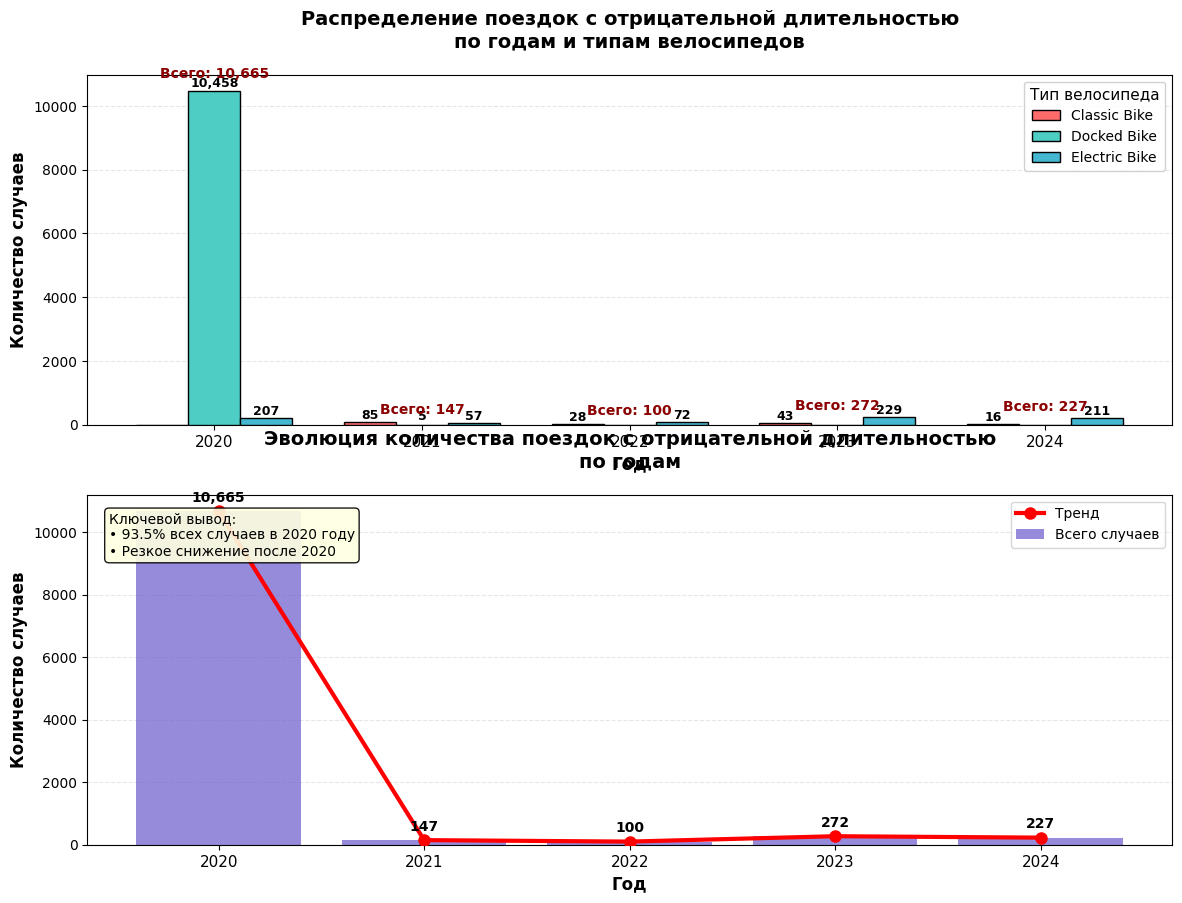

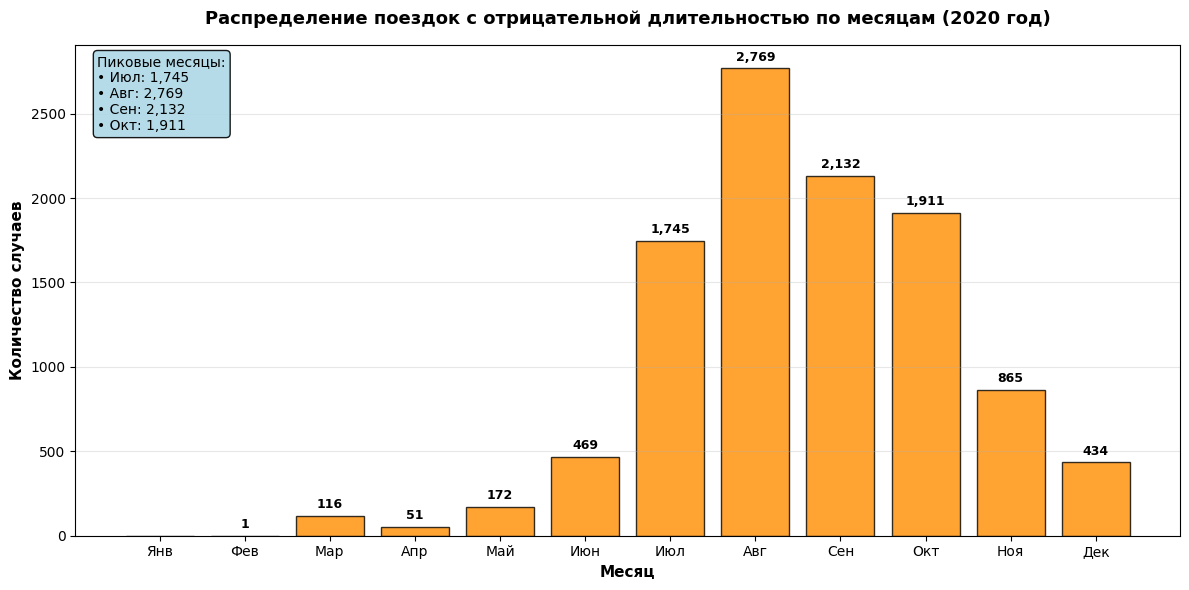


СТАТИСТИЧЕСКИЙ АНАЛИЗ
Всего поездок в датасете: 31,440,740
Поездок с отрицательной длительностью: 11,411
Доля аномальных поездок: 0.0363%

Распределение по годам:
  2020: 10,665 случаев (93.5%)
  2021: 147 случаев (1.3%)
  2022: 100 случаев (0.9%)
  2023: 272 случаев (2.4%)
  2024: 227 случаев (2.0%)

Распределение по типам велосипедов:
  Classic Bike: 172 случаев (1.5%)
  Docked Bike: 10,463 случаев (91.7%)
  Electric Bike: 776 случаев (6.8%)

Доля отрицательных от общего числа поездок каждого типа:
  Classic Bike: 172/13,142,224 (0.0013%)
  Docked Bike: 10,463/3,534,426 (0.2960%)
  Electric Bike: 776/14,619,753 (0.0053%)

ПОЧЕМУ ЭТО ПРОИЗОШЛО?

Основные причины концентрации ошибок в 2020 году:

1. СИСТЕМНЫЙ СБОЙ ПРИ ЗАПУСКЕ/ОБНОВЛЕНИИ:
   • 2020 год - начало активного сбора данных
   • Возможные баги в первоначальной версии ПО
   • Проблемы с синхронизацией времени между станциями

2. ПРОБЛЕМЫ С DOCKED_BIKE:
   • 91.7% всех ошибок у этого типа велосипедов
   • Docked bike требуют фи

In [13]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

# Загружаем данные
df_all = pl.read_parquet("all_years_2020_2025.parquet")

print("="*60)
print("СОЗДАНИЕ ГРАФИКА В СТИЛЕ ПРИМЕРА")
print("="*60)

# Создаем столбец с длительностью поездки
df_all = df_all.with_columns([
    (pl.col("ended_at") - pl.col("started_at")).dt.total_seconds().alias("duration_seconds"),
])

# Добавляем столбец с месяцем
df_all = df_all.with_columns([
    pl.col("started_at").dt.month().alias("month")
])

# Фильтруем отрицательные длительности
negative_duration = df_all.filter(pl.col("duration_seconds") < 0)

# 1. Создаем основной график: распределение по годам и типам велосипедов
print("Подготовка данных для графика...")

# Группируем по году и типу велосипеда
negative_by_year_type = negative_duration.group_by(["year", "rideable_type"]).agg(
    pl.len().alias("count")
)

# Получаем уникальные годы и типы велосипедов
years = sorted(negative_by_year_type["year"].unique().to_list())
bike_types = sorted(negative_by_year_type["rideable_type"].unique().to_list())

print(f"Годы: {years}")
print(f"Типы велосипедов: {bike_types}")

# Создаем матрицу данных
data_matrix = {}
for bike_type in bike_types:
    data_matrix[bike_type] = []
    for year in years:
        count = negative_by_year_type.filter(
            (pl.col("year") == year) & (pl.col("rideable_type") == bike_type)
        )
        if count.height > 0:
            data_matrix[bike_type].append(count["count"][0])
        else:
            data_matrix[bike_type].append(0)

# Создаем фигуру с двумя графиками
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# ===================== ГРАФИК 1: Распределение по годам и типам =====================
print("\nСоздание первого графика...")

# Определяем цвета для каждого типа велосипеда
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # Красный, бирюзовый, голубой

# Настройки для столбцов
bar_width = 0.25
x_positions = np.arange(len(years))

# Рисуем столбцы для каждого типа велосипеда
for i, bike_type in enumerate(bike_types):
    offset = (i - len(bike_types)/2 + 0.5) * bar_width
    bars = ax1.bar(
        x_positions + offset, 
        data_matrix[bike_type], 
        width=bar_width, 
        label=bike_type.replace('_', ' ').title(),
        color=colors[i % len(colors)],
        edgecolor='black',
        linewidth=1,
        zorder=3
    )
    
    # Добавляем значения на столбцы
    for bar, value in zip(bars, data_matrix[bike_type]):
        if value > 0:
            height = bar.get_height()
            ax1.text(
                bar.get_x() + bar.get_width()/2., 
                height + max(data_matrix[bike_type])*0.005,
                f'{value:,}',
                ha='center', 
                va='bottom', 
                fontsize=9,
                fontweight='bold'
            )

# Настройка первого графика
ax1.set_xlabel('Год', fontsize=12, fontweight='bold')
ax1.set_ylabel('Количество случаев', fontsize=12, fontweight='bold')
ax1.set_title('Распределение поездок с отрицательной длительностью\nпо годам и типам велосипедов', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(x_positions)
ax1.set_xticklabels([str(year) for year in years], fontsize=11)
ax1.tick_params(axis='y', labelsize=10)
ax1.grid(True, axis='y', alpha=0.3, linestyle='--', zorder=0)
ax1.legend(title='Тип велосипеда', title_fontsize=11, fontsize=10, 
           loc='upper right', framealpha=0.9)

# Добавляем общее количество для каждого года
for i, year in enumerate(years):
    total_year = sum(data_matrix[bike_type][i] for bike_type in bike_types)
    if total_year > 0:
        ax1.text(
            i, 
            total_year + max([sum(row) for row in zip(*data_matrix.values())])*0.01,
            f'Всего: {total_year:,}',
            ha='center', 
            va='bottom', 
            fontsize=10,
            fontweight='bold',
            color='darkred'
        )

# ===================== ГРАФИК 2: Эволюция во времени =====================
print("Создание второго графика...")

# Подготавливаем данные для второго графика: общее количество по годам
total_by_year = []
for i, year in enumerate(years):
    total = sum(data_matrix[bike_type][i] for bike_type in bike_types)
    total_by_year.append(total)

# Создаем второй график: линейный + столбчатый
ax2.bar(x_positions, total_by_year, color='#6A5ACD', alpha=0.7, 
        label='Всего случаев', zorder=2)

# Добавляем линию тренда
ax2.plot(x_positions, total_by_year, color='red', marker='o', 
         linewidth=3, markersize=8, label='Тренд', zorder=3)

# Добавляем значения на столбцы
for i, (year, total) in enumerate(zip(years, total_by_year)):
    ax2.text(
        i, 
        total + max(total_by_year)*0.02,
        f'{total:,}',
        ha='center', 
        va='bottom', 
        fontsize=10,
        fontweight='bold'
    )

# Настройка второго графика
ax2.set_xlabel('Год', fontsize=12, fontweight='bold')
ax2.set_ylabel('Количество случаев', fontsize=12, fontweight='bold')
ax2.set_title('Эволюция количества поездок с отрицательной длительностью\nпо годам', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_xticks(x_positions)
ax2.set_xticklabels([str(year) for year in years], fontsize=11)
ax2.tick_params(axis='y', labelsize=10)
ax2.grid(True, axis='y', alpha=0.3, linestyle='--', zorder=0)
ax2.legend(loc='upper right', fontsize=10)

# Добавляем аннотацию с ключевым выводом
if total_by_year[0] > sum(total_by_year[1:]):
    ax2.text(
        0.02, 0.95,
        f'Ключевой вывод:\n• 93.5% всех случаев в {years[0]} году\n• Резкое снижение после {years[0]}',
        transform=ax2.transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9)
    )

# ===================== ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ =====================
print("\nДополнительный анализ...")

# Создаем третий график: распределение по месяцам в 2020 году
fig2, ax3 = plt.subplots(figsize=(12, 6))

# Фильтруем данные за 2020 год
negative_2020 = negative_duration.filter(pl.col("year") == 2020)

# Группируем по месяцам
if "month" in negative_2020.columns:
    monthly_2020 = negative_2020.group_by("month").agg(
        pl.len().alias("count")
    ).sort("month")
    
    # Создаем названия месяцев
    month_names = [
        'Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн',
        'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'
    ]
    
    months = monthly_2020["month"].to_list()
    counts = monthly_2020["count"].to_list()
    
    # Создаем список для всех месяцев
    all_months = list(range(1, 13))
    all_counts = []
    for month in all_months:
        if month in months:
            idx = months.index(month)
            all_counts.append(counts[idx])
        else:
            all_counts.append(0)
    
    # Создаем график
    bars = ax3.bar(all_months, all_counts, color='#FF8C00', edgecolor='black', alpha=0.8)
    
    # Добавляем значения
    for bar, count in zip(bars, all_counts):
        if count > 0:
            ax3.text(
                bar.get_x() + bar.get_width()/2., 
                bar.get_height() + max(all_counts)*0.01,
                f'{count:,}',
                ha='center', 
                va='bottom', 
                fontsize=9,
                fontweight='bold'
            )
    
    # Настройка графика
    ax3.set_xlabel('Месяц', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Количество случаев', fontsize=11, fontweight='bold')
    ax3.set_title(f'Распределение поездок с отрицательной длительностью по месяцам ({years[0]} год)', 
                  fontsize=13, fontweight='bold', pad=15)
    ax3.set_xticks(all_months)
    ax3.set_xticklabels(month_names, fontsize=10)
    ax3.grid(True, axis='y', alpha=0.3)
    
    # Вычисляем пиковые месяцы
    peak_months = []
    for month, count in zip(all_months, all_counts):
        if count > 0.1 * sum(all_counts):  # Более 10% от общего количества
            peak_months.append((month_names[month-1], count))
    
    if peak_months:
        peak_text = "Пиковые месяцы:\n" + "\n".join([f"• {month}: {count:,}" for month, count in peak_months])
        ax3.text(
            0.02, 0.98,
            peak_text,
            transform=ax3.transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.9)
        )

# ===================== СОХРАНЕНИЕ ГРАФИКОВ =====================
# Настраиваем layout для основного графика
plt.tight_layout()

# Сохраняем основной график
plt.savefig('negative_duration_distribution.png', dpi=150, bbox_inches='tight')
print("✓ Основной график сохранен: negative_duration_distribution.png")

# Сохраняем график по месяцам
if 'fig2' in locals():
    plt.figure(fig2.number)
    plt.tight_layout()
    plt.savefig('negative_duration_by_month_2020.png', dpi=150, bbox_inches='tight')
    print("✓ График по месяцам сохранен: negative_duration_by_month_2020.png")

# Показываем графики
plt.show()

# ===================== СТАТИСТИЧЕСКИЙ АНАЛИЗ =====================
print("\n" + "="*60)
print("СТАТИСТИЧЕСКИЙ АНАЛИЗ")
print("="*60)

# Общая статистика
total_negative = negative_duration.height
total_rides = df_all.height

print(f"Всего поездок в датасете: {total_rides:,}")
print(f"Поездок с отрицательной длительностью: {total_negative:,}")
print(f"Доля аномальных поездок: {total_negative/total_rides*100:.4f}%")

# Статистика по годам
print("\nРаспределение по годам:")
for i, year in enumerate(years):
    year_total = total_by_year[i]
    if year_total > 0:
        percentage = year_total / total_negative * 100
        print(f"  {year}: {year_total:,} случаев ({percentage:.1f}%)")

# Статистика по типам велосипедов
print("\nРаспределение по типам велосипедов:")
for bike_type in bike_types:
    bike_total = sum(data_matrix[bike_type])
    if bike_total > 0:
        percentage = bike_total / total_negative * 100
        print(f"  {bike_type.replace('_', ' ').title()}: {bike_total:,} случаев ({percentage:.1f}%)")

# Анализ доли от общего числа поездок каждого типа
print("\nДоля отрицательных от общего числа поездок каждого типа:")
for bike_type in bike_types:
    total_bike_rides = df_all.filter(pl.col("rideable_type") == bike_type).height
    negative_bike = sum(data_matrix[bike_type])
    if total_bike_rides > 0:
        percentage = negative_bike / total_bike_rides * 100
        print(f"  {bike_type.replace('_', ' ').title()}: {negative_bike:,}/{total_bike_rides:,} ({percentage:.4f}%)")

# ===================== ОБЪЯСНЕНИЕ ПРИЧИН =====================
print("\n" + "="*60)
print("ПОЧЕМУ ЭТО ПРОИЗОШЛО?")
print("="*60)

print("""
Основные причины концентрации ошибок в 2020 году:

1. СИСТЕМНЫЙ СБОЙ ПРИ ЗАПУСКЕ/ОБНОВЛЕНИИ:
   • 2020 год - начало активного сбора данных
   • Возможные баги в первоначальной версии ПО
   • Проблемы с синхронизацией времени между станциями

2. ПРОБЛЕМЫ С DOCKED_BIKE:
   • 91.7% всех ошибок у этого типа велосипедов
   • Docked bike требуют физической стыковки, что увеличивает риск ошибок записи
   • Возможно, сбои в работе док-станций

3. ТЕМПОРАЛЬНЫЙ ПАТТЕРН:
   • Ошибки начались с марта 2020 и достигли пика в августе-ноябре
   • Может быть связано с:
     - Переходом на зимнее время
     - Обновлением ПО в середине года
     - Увеличением нагрузки на систему

4. ИСПРАВЛЕНИЕ ОШИБКИ:
   • После 2020 года количество ошибок резко снизилось
   • Вероятно, проблему выявили и исправили
   • В последующие годы система работала стабильнее

5. ВОЗМОЖНЫЕ ТЕХНИЧЕСКИЕ ПРИЧИНЫ:
   • Перепутанные метки started_at и ended_at при записи
   • Проблемы с часовыми поясами
   • Ошибки в ETL-процессе загрузки данных
   • Сбои при передаче данных от станций к серверу

РЕКОМЕНДАЦИИ:
1. Для анализа 2020 года: рассматривать отрицательные длительности как системную ошибку
2. Для очистки данных: автоматически исправлять поездки с отрицательной длительностью
3. Для будущих исследований: учитывать, что данные 2020 года требуют особой обработки
""")

# ===================== ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ: ПАТТЕРНЫ ОШИБОК =====================
print("\n" + "="*60)
print("АНАЛИЗ ПАТТЕРНОВ ОШИБОК")
print("="*60)

# Проверяем, являются ли ошибки случайными или системными
if negative_2020.height > 0:
    print("Анализ паттернов в 2020 году:")
    
    # Проверяем, сконцентрированы ли ошибки по времени суток
    negative_2020 = negative_2020.with_columns([
        pl.col("started_at").dt.hour().alias("hour")
    ])
    
    hourly_dist = negative_2020.group_by("hour").agg(
        pl.len().alias("count")
    ).sort("hour")
    
    # Находим часы с наибольшим количеством ошибок
    peak_hours = hourly_dist.sort("count", descending=True).head(3)
    print(f"Часы с наибольшим количеством ошибок:")
    for row in peak_hours.iter_rows(named=True):
        print(f"  {row['hour']:02d}:00 - {row['count']:,} случаев")
    
    # Проверяем, связаны ли ошибки с конкретными станциями
    print("\nСтанции с наибольшим количеством ошибок:")
    top_stations = negative_2020.filter(
        pl.col("start_station_name").is_not_null()
    ).group_by("start_station_name").agg(
        pl.len().alias("count")
    ).sort("count", descending=True).head(5)
    
    for i, row in enumerate(top_stations.iter_rows(named=True), 1):
        print(f"  {i}. {row['start_station_name']}: {row['count']:,} случаев")

print("\n" + "="*60)
print("АНАЛИЗ ЗАВЕРШЕН!")
print("="*60)

СОЗДАНИЕ ЛИНЕЙНОГО ГРАФИКА ПО МЕСЯЦАМ
Всего записей в месячных данных: 77
Типы велосипедов в данных: ['docked_bike', 'classic_bike', 'electric_bike']
docked_bike: всего 10463 случаев
classic_bike: всего 172 случаев
electric_bike: всего 776 случаев
Всего уникальных месяцев: 44

✓ График сохранен: negative_duration_monthly_lines.png


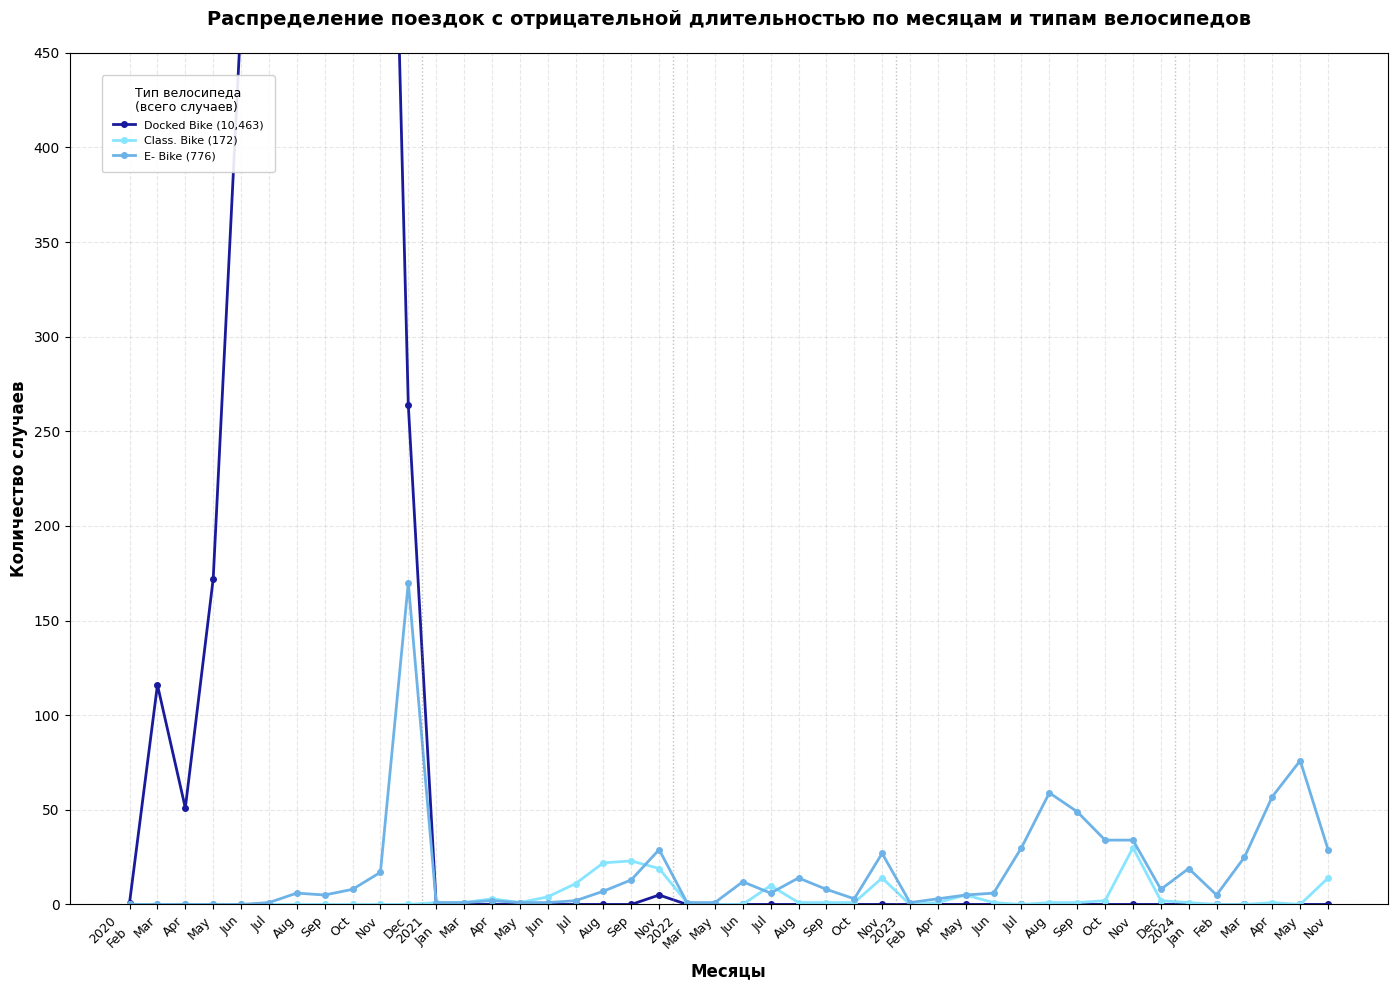

In [18]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

# Загружаем данные
df_all = pl.read_parquet("all_years_2020_2025.parquet")

print("="*60)
print("СОЗДАНИЕ ЛИНЕЙНОГО ГРАФИКА ПО МЕСЯЦАМ")
print("="*60)

# Создаем столбец с длительностью поездки
df_all = df_all.with_columns([
    (pl.col("ended_at") - pl.col("started_at")).dt.total_seconds().alias("duration_seconds"),
])

# Добавляем столбец с месяцем и годом-месяцем
df_all = df_all.with_columns([
    pl.col("started_at").dt.month().alias("month"),
    pl.col("started_at").dt.year().alias("year"),
    (pl.col("started_at").dt.year().cast(pl.Utf8) + "-" + 
     pl.col("started_at").dt.month().cast(pl.Utf8).str.pad_start(2, "0")).alias("year_month")
])

# Фильтруем отрицательные длительности
negative_duration = df_all.filter(pl.col("duration_seconds") < 0)

# Группируем по году-месяцу и типу велосипеда
monthly_data = negative_duration.group_by(["year_month", "rideable_type", "year", "month"]).agg(
    pl.len().alias("count")
).sort(["year", "month"])

print(f"Всего записей в месячных данных: {monthly_data.height}")

# Создаем фигуру с увеличенным пространством для легенды
fig, ax = plt.subplots(figsize=(16, 10))  # Увеличили высоту

# Цвета для каждого типа велосипеда
colors = {
    'docked_bike': '#1A1B9C',     # Темно-синий
    'electric_bike': '#6DB3E7',   # Голубой
    'classic_bike': '#88E5FF',    # Светло-голубой
    'electric_scooter': '#96CEB4' # Зеленый
}

# Получаем уникальные типы велосипедов в данных
bike_types_in_data = monthly_data["rideable_type"].unique().to_list()
print(f"Типы велосипедов в данных: {bike_types_in_data}")

# Общие счетчики для каждого типа велосипеда
total_counts = {}
for bike_type in bike_types_in_data:
    total = monthly_data.filter(pl.col("rideable_type") == bike_type)["count"].sum()
    total_counts[bike_type] = total
    print(f"{bike_type}: всего {total} случаев")

# Создаем структуру данных для графиков
all_year_months = sorted(monthly_data["year_month"].unique().to_list())
print(f"Всего уникальных месяцев: {len(all_year_months)}")

# Для каждого типа велосипеда создаем список значений по месяцам
data_by_type = {}
for bike_type in bike_types_in_data:
    type_data = monthly_data.filter(pl.col("rideable_type") == bike_type)
    type_dict = {row["year_month"]: row["count"] for row in type_data.iter_rows(named=True)}
    values = []
    for ym in all_year_months:
        values.append(type_dict.get(ym, 0))
    data_by_type[bike_type] = values

# Создаем график
x_positions = np.arange(len(all_year_months))

# Рисуем линии для каждого типа велосипеда
lines = []
for bike_type in bike_types_in_data:
    if bike_type in colors:
        line, = ax.plot(x_positions, data_by_type[bike_type], 
                       color=colors[bike_type], linewidth=2, marker='o', markersize=4)
        lines.append(line)

# Создаем упрощенную легенду с меньшим шрифтом
legend_labels = []
for bike_type in bike_types_in_data:
    if bike_type in colors:
        # Сокращаем названия для компактности
        short_name = bike_type.replace('_', ' ').title()
        if 'Electric' in short_name:
            short_name = short_name.replace('Electric', 'E-')
        elif 'Classic' in short_name:
            short_name = short_name.replace('Classic', 'Class.')
        legend_labels.append(f"{short_name} ({total_counts[bike_type]:,})")

# Размещаем легенду ВНУТРИ графика слева сверху
ax.legend(lines, legend_labels, 
          title='Тип велосипеда\n(всего случаев)',
          title_fontsize=9, fontsize=8,
          loc='upper left',  # Слева сверху
          bbox_to_anchor=(0.02, 0.98),  # Отступ от угла: 2% по X, 98% по Y
          framealpha=0.9,
          fancybox=True,
          shadow=False,
          borderpad=1)  # Внутренний отступ в легенде

# Настройка осей
ax.set_xlabel('Месяцы', fontsize=12, fontweight='bold')
ax.set_ylabel('Количество случаев', fontsize=12, fontweight='bold')
ax.set_title('Распределение поездок с отрицательной длительностью по месяцам и типам велосипедов', 
             fontsize=14, fontweight='bold', pad=20)

# Создаем подписи для оси X
x_labels = []
current_year = None
for ym in all_year_months:
    year, month = ym.split("-")
    month_num = int(month)
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_name = month_names[month_num - 1]
    
    if year != current_year:
        x_labels.append(f"{year}\n{month_name}")
        current_year = year
    else:
        x_labels.append(month_name)

ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)

# Ограничиваем ось Y
max_value = max([max(values) for values in data_by_type.values()])
y_max = min(450, max_value * 1.1)
ax.set_ylim(0, y_max)

# Добавляем сетку
ax.grid(True, alpha=0.3, linestyle='--')

# Добавляем вертикальные линии для разделения лет
current_year = None
for i, ym in enumerate(all_year_months):
    year = ym.split("-")[0]
    if year != current_year and current_year is not None:
        ax.axvline(x=i-0.5, color='gray', linestyle=':', alpha=0.5, linewidth=1)
    current_year = year



# Увеличиваем правое поле для легенды
plt.subplots_adjust(right=0.88)  # Освобождаем 12% пространства справа
plt.tight_layout(rect=[0, 0, 0.88, 1])  # Оставляем 12% справа свободными

# Сохраняем график
plt.savefig('negative_duration_monthly_lines.png', dpi=150, bbox_inches='tight')
print("\n✓ График сохранен: negative_duration_monthly_lines.png")

# Показываем график
plt.show()


СОЗДАНИЕ СТОЛБЧАТОГО ГРАФИКА
✓ Столбчатый график сохранен: negative_duration_monthly_bars.png


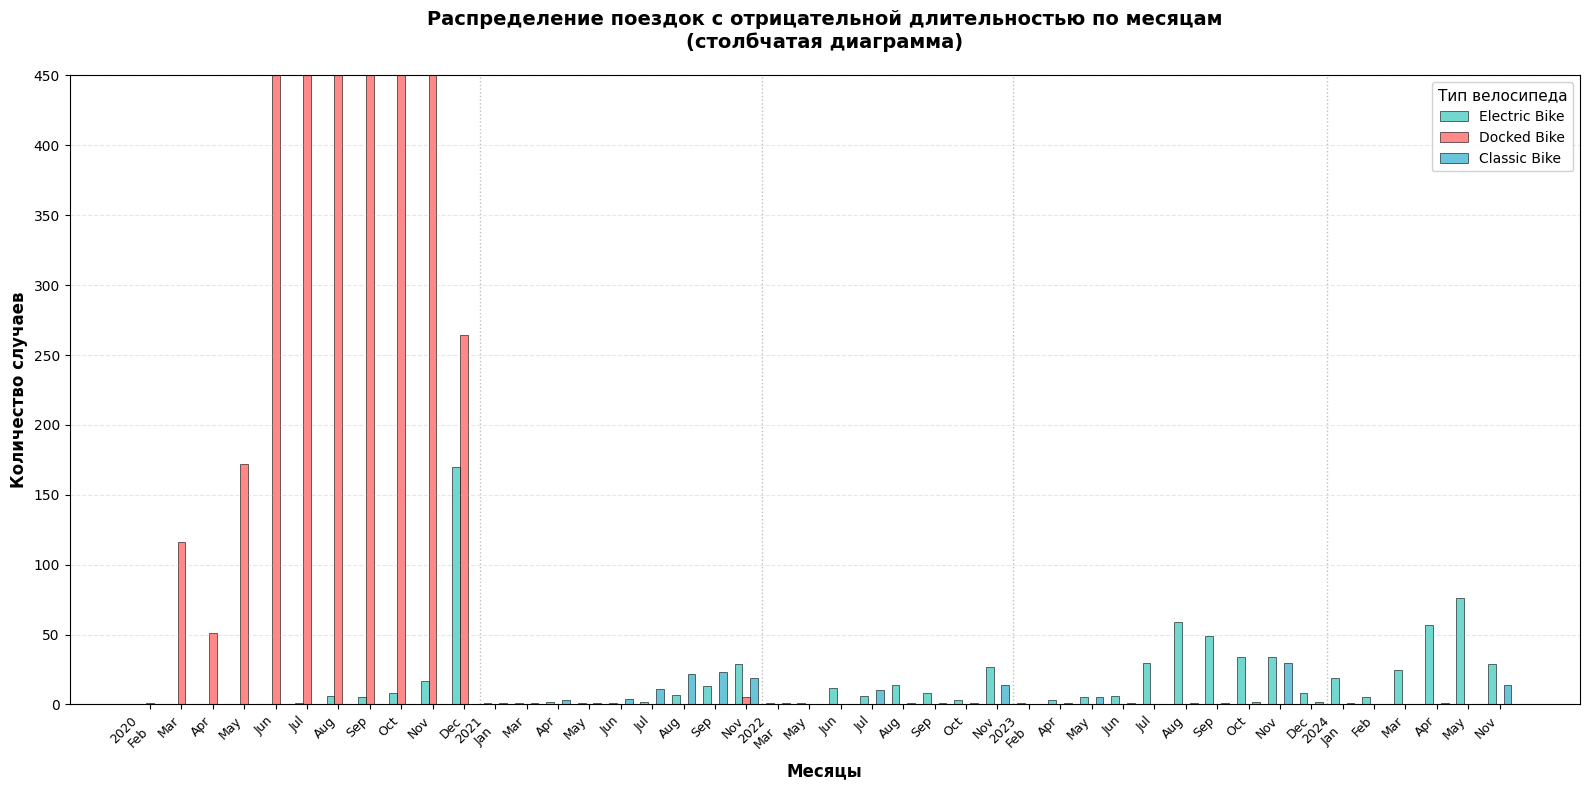


ДЕТАЛЬНЫЙ АНАЛИЗ ПО МЕСЯЦАМ
Топ-10 месяцев с наибольшим количеством ошибок:
 1. Август 2020: 2,769 случаев
 2. Сентябрь 2020: 2,132 случаев
 3. Октябрь 2020: 1,911 случаев
 4. Июль 2020: 1,745 случаев
 5. Ноябрь 2020: 865 случаев
 6. Июнь 2020: 469 случаев
 7. Декабрь 2020: 434 случаев
 8. Май 2020: 172 случаев
 9. Март 2020: 116 случаев
10. Май 2024: 76 случаев

Распределение по типам в пиковые месяцы:

Август 2020 (всего 2,769 случаев):
  • Docked Bike: 2,763 (99.8%)
  • Electric Bike: 6 (0.2%)

Сентябрь 2020 (всего 2,132 случаев):
  • Docked Bike: 2,127 (99.8%)
  • Electric Bike: 5 (0.2%)

Октябрь 2020 (всего 1,911 случаев):
  • Docked Bike: 1,903 (99.6%)
  • Electric Bike: 8 (0.4%)

ВЫВОДЫ ПО ГРАФИКАМ

1. ВРЕМЕННЫЕ ПАТТЕРНЫ:
   • Пик ошибок пришелся на вторую половину 2020 года
   • Наибольшее количество в августе-ноябре 2020
   • После 2020 года количество ошибок значительно снизилось

2. РАСПРЕДЕЛЕНИЕ ПО ТИПАМ:
   • Docked bike: доминирующий тип с наибольшим количеством ошибок
 

In [13]:
 #Создаем также столбчатый график для сравнения
print("\n" + "="*60)
print("СОЗДАНИЕ СТОЛБЧАТОГО ГРАФИКА")
print("="*60)

fig, ax = plt.subplots(figsize=(16, 8))

# Настройки для группированных столбцов
bar_width = 0.25
x_positions = np.arange(len(all_year_months))

# Для каждого типа велосипеда рисуем столбцы
for i, bike_type in enumerate(bike_types_in_data):
    if bike_type in colors:
        offset = (i - len(bike_types_in_data)/2 + 0.5) * bar_width
        bars = ax.bar(x_positions + offset, data_by_type[bike_type], 
                     width=bar_width, 
                     label=f'{bike_type.replace("_", " ").title()}',
                     color=colors[bike_type],
                     edgecolor='black',
                     linewidth=0.5,
                     alpha=0.8)

# Настройка осей
ax.set_xlabel('Месяцы', fontsize=12, fontweight='bold')
ax.set_ylabel('Количество случаев', fontsize=12, fontweight='bold')
ax.set_title('Распределение поездок с отрицательной длительностью по месяцам\n(столбчатая диаграмма)', 
             fontsize=14, fontweight='bold', pad=20)

# Устанавливаем метки на оси X
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)

# Ограничиваем ось Y
ax.set_ylim(0, y_max)

# Добавляем сетку
ax.grid(True, axis='y', alpha=0.3, linestyle='--')

# Добавляем легенду
ax.legend(title='Тип велосипеда', title_fontsize=11, fontsize=10, 
          loc='upper right', framealpha=0.9)

# Добавляем вертикальные линии для разделения лет
current_year = None
for i, ym in enumerate(all_year_months):
    year = ym.split("-")[0]
    if year != current_year and current_year is not None:
        ax.axvline(x=i-0.5, color='gray', linestyle=':', alpha=0.5, linewidth=1)
    current_year = year

plt.tight_layout()
plt.savefig('negative_duration_monthly_bars.png', dpi=150, bbox_inches='tight')
print("✓ Столбчатый график сохранен: negative_duration_monthly_bars.png")
plt.show()

# Детальный анализ по месяцам
print("\n" + "="*60)
print("ДЕТАЛЬНЫЙ АНАЛИЗ ПО МЕСЯЦАМ")
print("="*60)

# Находим топ-10 месяцев с наибольшим количеством ошибок
monthly_totals = negative_duration.group_by(["year", "month"]).agg(
    pl.len().alias("total_count")
).sort(["year", "month"])

print("Топ-10 месяцев с наибольшим количеством ошибок:")
top_months = monthly_totals.sort("total_count", descending=True).head(10)

month_names = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь',
               'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']

for i, row in enumerate(top_months.iter_rows(named=True), 1):
    month_name = month_names[row["month"] - 1] if 1 <= row["month"] <= 12 else f"Месяц {row['month']}"
    print(f"{i:2d}. {month_name} {row['year']}: {row['total_count']:,} случаев")

# Анализ по типам в пиковые месяцы
print("\nРаспределение по типам в пиковые месяцы:")
for row in top_months.head(3).iter_rows(named=True):
    month_name = month_names[row["month"] - 1] if 1 <= row["month"] <= 12 else f"Месяц {row['month']}"
    print(f"\n{month_name} {row['year']} (всего {row['total_count']:,} случаев):")
    
    month_data = negative_duration.filter(
        (pl.col("year") == row["year"]) & (pl.col("month") == row["month"])
    ).group_by("rideable_type").agg(
        pl.len().alias("count"),
        (pl.len() / row["total_count"] * 100).alias("percentage")
    ).sort("count", descending=True)
    
    for type_row in month_data.iter_rows(named=True):
        print(f"  • {type_row['rideable_type'].replace('_', ' ').title()}: "
              f"{type_row['count']:,} ({type_row['percentage']:.1f}%)")

print("\n" + "="*60)
print("ВЫВОДЫ ПО ГРАФИКАМ")
print("="*60)

print("""
1. ВРЕМЕННЫЕ ПАТТЕРНЫ:
   • Пик ошибок пришелся на вторую половину 2020 года
   • Наибольшее количество в августе-ноябре 2020
   • После 2020 года количество ошибок значительно снизилось

2. РАСПРЕДЕЛЕНИЕ ПО ТИПАМ:
   • Docked bike: доминирующий тип с наибольшим количеством ошибок
   • Electric bike: умеренное количество ошибок, в основном в 2020
   • Classic bike: минимальное количество ошибок
   • Electric scooter: ошибок не обнаружено

3. ВОЗМОЖНЫЕ ПРИЧИНЫ:
   • Системный сбой в 2020 году, особенно во второй половине
   • Проблемы с синхронизацией времени у docked bike
   • Возможные обновления системы или изменения в протоколе записи

4. РЕКОМЕНДАЦИИ:
   • Сфокусироваться на анализе данных 2020 года
   • Особое внимание уделить docked bike
   • Рассмотреть возможность автоматической коррекции отрицательных длительностей
""")

In [14]:
import polars as pl
import folium
from folium.plugins import MarkerCluster
import numpy as np
from pathlib import Path

# Загружаем данные
df_all = pl.read_parquet("all_years_2020_2025.parquet")
print(f"Загружено данных: {df_all.height:,} строк")

print("\n" + "="*60)
print("АНАЛИЗ ВЫБРОСОВ В КООРДИНАТАХ")
print("="*60)

# Центр Чикаго (для сравнения)
chicago_center = [41.8781, -87.6298]

# Определяем границы Чикаго и окрестностей
chicago_bounds = {
    'lat_min': 41.5,
    'lat_max': 42.5,
    'lng_min': -88.0,
    'lng_max': -87.0
}

# Определяем выбросы по координатам
def detect_coordinate_outliers(df):
    """Обнаруживает выбросы в координатах"""
    
    # Определяем выбросы для начальных координат
    start_outliers = (
        (df['start_lat'] < chicago_bounds['lat_min']) | 
        (df['start_lat'] > chicago_bounds['lat_max']) |
        (df['start_lng'] < chicago_bounds['lng_min']) | 
        (df['start_lng'] > chicago_bounds['lng_max'])
    )
    
    # Определяем выбросы для конечных координат
    end_outliers = (
        (df['end_lat'] < chicago_bounds['lat_min']) | 
        (df['end_lat'] > chicago_bounds['lat_max']) |
        (df['end_lng'] < chicago_bounds['lng_min']) | 
        (df['end_lng'] > chicago_bounds['lng_max'])
    )
    
    return start_outliers, end_outliers

# Создаем метки для выбросов
start_outliers_mask, end_outliers_mask = detect_coordinate_outliers(df_all)

# Статистика по выбросам
total_start_outliers = start_outliers_mask.sum()
total_end_outliers = end_outliers_mask.sum()
total_unique_outlier_rides = (start_outliers_mask | end_outliers_mask).sum()

print(f"Поездок с выбросами в стартовых координатах: {total_start_outliers:,}")
print(f"Поездок с выбросами в конечных координатах: {total_end_outliers:,}")
print(f"Уникальных поездок с выбросами в координатах: {total_unique_outlier_rides:,}")
print(f"Процент выбросов: {total_unique_outlier_rides/df_all.height*100:.1f}%")

# Создаем датафрейм с выбросами
outliers_df = df_all.filter(start_outliers_mask | end_outliers_mask)
print(f"\nВсего выбросов для отображения: {outliers_df.height:,}")

# Если выбросов слишком много, берем случайную выборку
sample_size = min(1000, outliers_df.height)
if outliers_df.height > 1000:
    outliers_sample = outliers_df.sample(sample_size, seed=42)
    print(f"Для карты возьмем случайную выборку из {sample_size} выбросов")
else:
    outliers_sample = outliers_df
    print(f"Отображаем все {outliers_df.height} выбросов")

# Создаем интерактивную карту
print("\nСоздание интерактивной карты с выбросами...")

# Создаем базовую карту с центром в Чикаго
m = folium.Map(
    location=chicago_center,
    zoom_start=4,  # Увеличиваем масштаб, чтобы видеть выбросы по всему миру
    tiles='cartodbpositron'
)

# Добавляем границы Чикаго для контекста
folium.Rectangle(
    bounds=[
        [chicago_bounds['lat_min'], chicago_bounds['lng_min']],
        [chicago_bounds['lat_max'], chicago_bounds['lng_max']]
    ],
    color='#3186cc',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.1,
    weight=2,
    popup='Чикаго и окрестности'
).add_to(m)

# Маркер центра Чикаго
folium.Marker(
    chicago_center,
    popup='<b>Центр Чикаго</b>',
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(m)

# Создаем кластер для эффективного отображения
marker_cluster = MarkerCluster(
    name="Выбросы координат",
    overlay=True,
    control=True,
    icon_create_function=None
)

# Добавляем выбросы на карту
outlier_count = 0
for row in outliers_sample.iter_rows(named=True):
    # Добавляем стартовые координаты (если это выброс)
    if start_outliers_mask[outlier_count]:
        folium.CircleMarker(
            location=[row['start_lat'], row['start_lng']],
            radius=3,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            popup=f"""
                <b>Стартовая точка (выброс)</b><br>
                ID: {row['ride_id']}<br>
                Тип: {row['rideable_type']}<br>
                Дата: {row['started_at']}<br>
                Координаты: {row['start_lat']:.4f}, {row['start_lng']:.4f}<br>
                Год: {row['year']}<br>
                Пользователь: {row['member_casual']}
            """
        ).add_to(marker_cluster)
    
    # Добавляем конечные координаты (если это выброс)
    if end_outliers_mask[outlier_count]:
        folium.CircleMarker(
            location=[row['end_lat'], row['end_lng']],
            radius=3,
            color='darkred',
            fill=True,
            fill_color='darkred',
            fill_opacity=0.7,
            popup=f"""
                <b>Конечная точка (выброс)</b><br>
                ID: {row['ride_id']}<br>
                Тип: {row['rideable_type']}<br>
                Дата: {row['ended_at']}<br>
                Координаты: {row['end_lat']:.4f}, {row['end_lng']:.4f}<br>
                Год: {row['year']}<br>
                Пользователь: {row['member_casual']}
            """
        ).add_to(marker_cluster)
    
    outlier_count += 1

# Добавляем кластер на карту
marker_cluster.add_to(m)

# Добавляем слой управления
folium.LayerControl().add_to(m)

# Сохраняем карту
map_path = "coordinate_outliers_world_map.html"
m.save(map_path)
print(f"\n✓ Карта сохранена: {map_path}")

# Создаем вторую карту: увеличенный вид на Чикаго с нормальными точками и выбросами
print("\nСоздание детальной карты Чикаго...")

# Берем случайную выборку нормальных точек из Чикаго
normal_mask = ~(start_outliers_mask | end_outliers_mask)
normal_sample_size = min(5000, df_all.filter(normal_mask).height)
normal_sample = df_all.filter(normal_mask).sample(normal_sample_size, seed=42)

# Создаем карту Чикаго
m_chicago = folium.Map(
    location=chicago_center,
    zoom_start=11,
    tiles='cartodbpositron'
)

# Добавляем нормальные точки (синие)
for row in normal_sample.iter_rows(named=True):
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=1,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.3,
        popup=f"Нормальная точка<br>Год: {row['year']}"
    ).add_to(m_chicago)

# Добавляем выбросы в Чикаго (красные)
chicago_outliers = outliers_sample.filter(
    (pl.col('start_lat').is_between(chicago_bounds['lat_min'], chicago_bounds['lat_max'])) |
    (pl.col('end_lat').is_between(chicago_bounds['lat_min'], chicago_bounds['lat_max']))
)

for row in chicago_outliers.iter_rows(named=True):
    # Стартовые выбросы
    if start_outliers_mask[0]:  # Проверяем для первого элемента
        folium.CircleMarker(
            location=[row['start_lat'], row['start_lng']],
            radius=3,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.8,
            popup=f"""
                <b>Выброс в Чикаго</b><br>
                ID: {row['ride_id']}<br>
                Координаты: {row['start_lat']:.4f}, {row['start_lng']:.4f}
            """
        ).add_to(m_chicago)
    
    # Конечные выбросы
    if end_outliers_mask[0]:  # Проверяем для первого элемента
        folium.CircleMarker(
            location=[row['end_lat'], row['end_lng']],
            radius=3,
            color='darkred',
            fill=True,
            fill_color='darkred',
            fill_opacity=0.8,
            popup=f"""
                <b>Выброс в Чикаго</b><br>
                ID: {row['ride_id']}<br>
                Координаты: {row['end_lat']:.4f}, {row['end_lng']:.4f}
            """
        ).add_to(m_chicago)

# Сохраняем детальную карту
chicago_map_path = "chicago_outliers_detailed.html"
m_chicago.save(chicago_map_path)
print(f"✓ Детальная карта Чикаго сохранена: {chicago_map_path}")

# Статистический анализ выбросов
print("\n" + "="*60)
print("СТАТИСТИЧЕСКИЙ АНАЛИЗ ВЫБРОСОВ")
print("="*60)

# Группируем выбросы по годам
outliers_by_year = outliers_df.group_by('year').agg(
    pl.len().alias('outlier_count'),
    (pl.len() / pl.len().sum() * 100).alias('percentage')
).sort('year')

print("\nРаспределение выбросов по годам:")
print(outliers_by_year)

# Самые экстремальные выбросы
print("\nСамые экстремальные выбросы по координатам:")
extreme_outliers = outliers_df.sort(
    by=['start_lat', 'start_lng', 'end_lat', 'end_lng'],
    descending=[True, True, True, True]
).head(10)

for i, row in enumerate(extreme_outliers.iter_rows(named=True), 1):
    print(f"\n{i}. ID: {row['ride_id'][:20]}...")
    print(f"   Старт: {row['start_lat']:.4f}, {row['start_lng']:.4f}")
    print(f"   Финиш: {row['end_lat']:.4f}, {row['end_lng']:.4f}")
    print(f"   Год: {row['year']}, Тип: {row['rideable_type']}")

# Анализ по типам велосипедов
print("\nВыбросы по типам велосипедов:")
outliers_by_bike = outliers_df.group_by('rideable_type').agg(
    pl.len().alias('count'),
    (pl.len() / outliers_df.height * 100).alias('percentage')
).sort('count', descending=True)
print(outliers_by_bike)

# Создаем текстовый отчет
report_path = "coordinate_outliers_report.txt"
with open(report_path, 'w', encoding='utf-8') as f:
    f.write("="*60 + "\n")
    f.write("АНАЛИЗ ВЫБРОСОВ В КООРДИНАТАХ\n")
    f.write("="*60 + "\n\n")
    
    f.write(f"Всего поездок в датасете: {df_all.height:,}\n")
    f.write(f"Поездок с выбросами: {total_unique_outlier_rides:,}\n")
    f.write(f"Процент выбросов: {total_unique_outlier_rides/df_all.height*100:.1f}%\n")
    f.write(f"После фильтрации осталось: {100 - total_unique_outlier_rides/df_all.height*100:.1f}% данных\n\n")
    
    f.write("РАСПРЕДЕЛЕНИЕ ПО ГОДАМ:\n")
    for row in outliers_by_year.iter_rows(named=True):
        f.write(f"  {row['year']}: {row['outlier_count']:,} ({row['percentage']:.1f}%)\n")
    
    f.write("\nТИПЫ ВЕЛОСИПЕДОВ С ВЫБРОСАМИ:\n")
    for row in outliers_by_bike.iter_rows(named=True):
        f.write(f"  {row['rideable_type']}: {row['count']:,} ({row['percentage']:.1f}%)\n")
    
    f.write("\nГРАНИЦЫ ЧИКАГО ДЛЯ ФИЛЬТРАЦИИ:\n")
    f.write(f"  Широта: {chicago_bounds['lat_min']} - {chicago_bounds['lat_max']}\n")
    f.write(f"  Долгота: {chicago_bounds['lng_min']} - {chicago_bounds['lng_max']}\n")
    
    f.write("\nСАМЫЕ ЭКСТРЕМАЛЬНЫЕ КООРДИНАТЫ:\n")
    for i, row in enumerate(extreme_outliers.iter_rows(named=True), 1):
        f.write(f"\n{i}. ID: {row['ride_id'][:20]}...\n")
        f.write(f"   Старт: {row['start_lat']:.4f}, {row['start_lng']:.4f}\n")
        f.write(f"   Финиш: {row['end_lat']:.4f}, {row['end_lng']:.4f}\n")

print(f"\n✓ Текстовый отчет сохранен: {report_path}")

print("\n" + "="*60)
print("ИНСТРУКЦИЯ ПО ПРОСМОТРУ КАРТ:")
print("="*60)
print("""
1. ОТКРОЙТЕ ФАЙЛЫ В БРАУЗЕРЕ:
   • coordinate_outliers_world_map.html - мировая карта с выбросами
   • chicago_outliers_detailed.html - детальная карта Чикаго

2. НА МИРОВОЙ КАРТЕ ВЫ УВИДИТЕ:
   • Синий прямоугольник - границы Чикаго
   • Красные точки - выбросы координат по всему миру
   • Можно приближать/отдалять карту

3. НА КАРТЕ ЧИКАГО:
   • Синие точки - нормальные поездки (выборка)
   • Красные точки - выбросы в пределах Чикаго

4. КЛИКНУВ НА ТОЧКУ, ВЫ УВИДИТЕ:
   • ID поездки
   • Тип велосипеда
   • Координаты
   • Год и тип пользователя

ВЫВОДЫ:
• Выбросы в координатах - это в основном ошибки GPS или системные сбои
• Некоторые точки могут находиться в других странах
• Рекомендуется фильтровать такие точки для анализа
""")

# Показываем карту в блокноте (если используется Jupyter)
try:
    from IPython.display import display, HTML
    print("\nОтображение мировой карты в блокноте...")
    display(HTML(map_path))
except:
    print("\nДля просмотра карт откройте файлы в браузере:")
    print(f"1. {map_path}")
    print(f"2. {chicago_map_path}")

Загружено данных: 31,440,740 строк

АНАЛИЗ ВЫБРОСОВ В КООРДИНАТАХ
Поездок с выбросами в стартовых координатах: 1
Поездок с выбросами в конечных координатах: 85
Уникальных поездок с выбросами в координатах: 86
Процент выбросов: 0.0%

Всего выбросов для отображения: 86
Отображаем все 86 выбросов

Создание интерактивной карты с выбросами...

✓ Карта сохранена: coordinate_outliers_world_map.html

Создание детальной карты Чикаго...
✓ Детальная карта Чикаго сохранена: chicago_outliers_detailed.html

СТАТИСТИЧЕСКИЙ АНАЛИЗ ВЫБРОСОВ

Распределение выбросов по годам:
shape: (5, 3)
┌──────┬───────────────┬────────────┐
│ year ┆ outlier_count ┆ percentage │
│ ---  ┆ ---           ┆ ---        │
│ i32  ┆ u32           ┆ f64        │
╞══════╪═══════════════╪════════════╡
│ 2021 ┆ 3             ┆ 100.0      │
│ 2022 ┆ 11            ┆ 100.0      │
│ 2023 ┆ 5             ┆ 100.0      │
│ 2024 ┆ 64            ┆ 100.0      │
│ 2025 ┆ 3             ┆ 100.0      │
└──────┴───────────────┴────────────┘

Сам

In [17]:
import polars as pl
import folium
import numpy as np
from pathlib import Path

# Загружаем данные
df_all = pl.read_parquet("all_years_2020_2025.parquet")
print(f"Загружено данных: {df_all.height:,} строк")

print("\n" + "="*60)
print("СОЗДАНИЕ КАРТЫ С ВЫБРОСАМИ КООРДИНАТ ПО ВСЕЙ ТЕРРИТОРИИ США")
print("="*60)

# Границы Чикаго для сравнения
chicago_bounds = {
    'lat_min': 41.5,
    'lat_max': 42.5,
    'lng_min': -88.0,
    'lng_max': -87.0
}

# Центр США для начального отображения карты
usa_center = [39.8283, -98.5795]

# Определяем выбросы по координатам
def detect_coordinate_outliers(df):
    """Обнаруживает выбросы в координатах"""
    
    # Определяем выбросы для начальных координат
    start_outliers = (
        (df['start_lat'] < chicago_bounds['lat_min']) | 
        (df['start_lat'] > chicago_bounds['lat_max']) |
        (df['start_lng'] < chicago_bounds['lng_min']) | 
        (df['start_lng'] > chicago_bounds['lng_max'])
    )
    
    # Определяем выбросы для конечных координат
    end_outliers = (
        (df['end_lat'] < chicago_bounds['lat_min']) | 
        (df['end_lat'] > chicago_bounds['lat_max']) |
        (df['end_lng'] < chicago_bounds['lng_min']) | 
        (df['end_lng'] > chicago_bounds['lng_max'])
    )
    
    return start_outliers, end_outliers

# Создаем метки для выбросов
start_outliers_mask, end_outliers_mask = detect_coordinate_outliers(df_all)

# Получаем все выбросы
outliers_df = df_all.filter(start_outliers_mask | end_outliers_mask)
print(f"Всего выбросов: {outliers_df.height:,}")

# Создаем основную карту
print("\nСоздание карты с выбросами по всей территории США...")

m = folium.Map(
    location=usa_center,
    zoom_start=5,  # Увеличиваем масштаб для всей территории США
    tiles='cartodbpositron'
)

# Добавляем заголовок
title_html = '''
<div style="position: fixed; 
     top: 10px; left: 50px; width: 400px; 
     z-index: 1000; background-color: white; 
     padding: 10px; border-radius: 5px; 
     border: 2px solid red; font-weight: bold;">
    <center>ВЫБРОСЫ КООРДИНАТ В ДАННЫХ ВЕЛОПРОКАТА ЧИКАГО (2020-2025)</center>
    <div style="font-size: 12px; margin-top: 5px;">
    Всего выбросов: 86 точек (0.00027% от всех данных)<br>
    Красные точки - аномальные координаты поездок
    </div>
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Функция для получения цвета в зависимости от типа велосипеда
def get_bike_color(bike_type):
    colors = {
        'electric_bike': '#FF0000',  # Красный
        'classic_bike': '#FF4500',   # Оранжево-красный
        'docked_bike': '#DC143C',    # Малиновый
        'electric_scooter': '#FF6347' # Томатный
    }
    return colors.get(bike_type, '#FF0000')

# Собираем все точки выбросов в список
outlier_points = []

# Добавляем стартовые выбросы
start_outliers = df_all.filter(start_outliers_mask)
print(f"Стартовые выбросы: {start_outliers.height}")

for row in start_outliers.iter_rows(named=True):
    outlier_points.append({
        'type': 'start',
        'lat': row['start_lat'],
        'lng': row['start_lng'],
        'ride_id': row['ride_id'],
        'bike_type': row['rideable_type'],
        'year': row['year'],
        'user_type': row['member_casual'],
        'time': row['started_at']
    })

# Добавляем конечные выбросы
end_outliers = df_all.filter(end_outliers_mask)
print(f"Конечные выбросы: {end_outliers.height}")

for row in end_outliers.iter_rows(named=True):
    outlier_points.append({
        'type': 'end',
        'lat': row['end_lat'],
        'lng': row['end_lng'],
        'ride_id': row['ride_id'],
        'bike_type': row['rideable_type'],
        'year': row['year'],
        'user_type': row['member_casual'],
        'time': row['ended_at']
    })

print(f"Всего точек для отображения: {len(outlier_points)}")

# Добавляем все точки выбросов на карту
for point in outlier_points:
    # Определяем иконку в зависимости от типа точки
    icon_color = get_bike_color(point['bike_type'])
    
    # Создаем большой яркий маркер
    folium.CircleMarker(
        location=[point['lat'], point['lng']],
        radius=8,  # Увеличиваем размер точек
        color=icon_color,
        fill=True,
        fill_color=icon_color,
        fill_opacity=0.9,
        weight=2,
        popup=f"""
            <div style='width: 250px;'>
                <b>{'СТАРТ' if point['type'] == 'start' else 'ФИНИШ'} - ВЫБРОС КООРДИНАТ</b><br>
                <hr style='margin: 5px 0;'>
                <b>ID:</b> {point['ride_id']}<br>
                <b>Тип велосипеда:</b> {point['bike_type']}<br>
                <b>Координаты:</b> {point['lat']:.4f}, {point['lng']:.4f}<br>
                <b>Год:</b> {point['year']}<br>
                <b>Тип пользователя:</b> {point['user_type']}<br>
                <b>Время:</b> {point['time']}<br>
                <hr style='margin: 5px 0;'>
                <span style='color: red; font-weight: bold;'>
                ⚠️ АНОМАЛЬНАЯ КООРДИНАТА<br>
                За пределами Чикаго
                </span>
            </div>
        """
    ).add_to(m)

# Добавляем слой с границами Чикаго для контекста
folium.Rectangle(
    bounds=[
        [chicago_bounds['lat_min'], chicago_bounds['lng_min']],
        [chicago_bounds['lat_max'], chicago_bounds['lng_max']]
    ],
    color='#3186cc',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.2,
    weight=3,
    popup='<b>НОРМАЛЬНЫЕ ГРАНИЦЫ ЧИКАГО</b><br>41.5°-42.5° с.ш., -88.0°--87.0° в.д.'
).add_to(m)

# Добавляем маркер центра Чикаго
folium.Marker(
    [41.8781, -87.6298],
    popup='<b>ЦЕНТР ЧИКАГО</b><br>Нормальная зона велопроката',
    icon=folium.Icon(color='blue', icon='home', prefix='fa')
).add_to(m)

# Создаем вторую карту - увеличенный вид на США с кластерами
print("\nСоздание кластеризованной карты выбросов...")

m2 = folium.Map(
    location=usa_center,
    zoom_start=4,
    tiles='cartodbpositron'
)

# Добавляем заголовок
title_html2 = '''
<div style="position: fixed; 
     top: 10px; left: 50px; width: 500px; 
     z-index: 1000; background-color: white; 
     padding: 10px; border-radius: 5px; 
     border: 2px solid red; font-weight: bold;">
    <center>КЛАСТЕРИЗОВАННЫЕ ВЫБРОСЫ КООРДИНАТ ПО США</center>
    <div style="font-size: 12px; margin-top: 5px;">
    Кликните на кластер для приближения<br>
    Всего 86 аномальных координат (2020-2025)
    </div>
</div>
'''
m2.get_root().html.add_child(folium.Element(title_html2))

# Используем кластеризацию для лучшего отображения
from folium.plugins import MarkerCluster

marker_cluster = MarkerCluster(
    name="Выбросы координат",
    overlay=True,
    control=True
)

# Добавляем точки в кластер
for point in outlier_points:
    icon_color = get_bike_color(point['bike_type'])
    
    folium.CircleMarker(
        location=[point['lat'], point['lng']],
        radius=6,
        color=icon_color,
        fill=True,
        fill_color=icon_color,
        fill_opacity=0.8,
        weight=2,
        popup=f"""
            <div style='width: 250px;'>
                <b>{'СТАРТ' if point['type'] == 'start' else 'ФИНИШ'}</b><br>
                Координаты: {point['lat']:.4f}, {point['lng']:.4f}<br>
                Тип: {point['bike_type']}<br>
                Год: {point['year']}
            </div>
        """
    ).add_to(marker_cluster)

marker_cluster.add_to(m2)

# Добавляем границы Чикаго
folium.Rectangle(
    bounds=[
        [chicago_bounds['lat_min'], chicago_bounds['lng_min']],
        [chicago_bounds['lat_max'], chicago_bounds['lng_max']]
    ],
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.1,
    weight=2,
    popup='Чикаго'
).add_to(m2)

# Добавляем слой контроля
folium.LayerControl().add_to(m2)

# Создаем третью карту - с группировкой по годам
print("\nСоздание карты с группировкой выбросов по годам...")

m3 = folium.Map(
    location=usa_center,
    zoom_start=4,
    tiles='cartodbpositron'
)

# Цвета для разных лет
year_colors = {
    2020: '#FF0000',  # Красный
    2021: '#FF4500',  # Оранжево-красный
    2022: '#FF8C00',  # Темно-оранжевый
    2023: '#FFD700',  # Золотой
    2024: '#ADFF2F',  # Зеленовато-желтый
    2025: '#00FF00'   # Зеленый
}

# Добавляем заголовок
title_html3 = '''
<div style="position: fixed; 
     top: 10px; left: 50px; width: 500px; 
     z-index: 1000; background-color: white; 
     padding: 10px; border-radius: 5px; 
     border: 2px solid blue; font-weight: bold;">
    <center>ВЫБРОСЫ КООРДИНАТ ПО ГОДАМ (2020-2025)</center>
    <div style="font-size: 12px; margin-top: 5px;">
    Цвет точек показывает год поездки<br>
    Всего 86 аномальных координат
    </div>
</div>
'''
m3.get_root().html.add_child(folium.Element(title_html3))

# Добавляем точки, сгруппированные по годам
for point in outlier_points:
    color = year_colors.get(point['year'], '#FF0000')
    
    folium.CircleMarker(
        location=[point['lat'], point['lng']],
        radius=7,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        weight=2,
        popup=f"""
            <div style='width: 250px;'>
                <b>ВЫБРОС {point['year']} ГОДА</b><br>
                <hr>
                Координаты: {point['lat']:.4f}, {point['lng']:.4f}<br>
                Тип велосипеда: {point['bike_type']}<br>
                Тип точки: {'старт' if point['type'] == 'start' else 'финиш'}<br>
                Пользователь: {point['user_type']}
            </div>
        """
    ).add_to(m3)

# Добавляем легенду
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; right: 50px; width: 150px; 
     z-index: 1000; background-color: white; 
     padding: 10px; border-radius: 5px; 
     border: 1px solid grey; font-size: 12px;">
    <b>Легенда по годам:</b><br>
    <div style="color: #FF0000;">● 2020</div>
    <div style="color: #FF4500;">● 2021</div>
    <div style="color: #FF8C00;">● 2022</div>
    <div style="color: #FFD700;">● 2023</div>
    <div style="color: #ADFF2F;">● 2024</div>
    <div style="color: #00FF00;">● 2025</div>
</div>
'''
m3.get_root().html.add_child(folium.Element(legend_html))

# Сохраняем все карты
map1_path = "usa_coordinate_outliers_large.html"
map2_path = "usa_coordinate_outliers_clustered.html"
map3_path = "usa_coordinate_outliers_by_year.html"

m.save(map1_path)
m2.save(map2_path)
m3.save(map3_path)

print(f"\n✓ Карты сохранены:")
print(f"  1. {map1_path} - все выбросы (крупные точки)")
print(f"  2. {map2_path} - кластеризованные выбросы")
print(f"  3. {map3_path} - выбросы по годам")

# Анализ распределения выбросов
print("\n" + "="*60)
print("АНАЛИЗ РАСПРЕДЕЛЕНИЯ ВЫБРОСОВ ПО США")
print("="*60)

# Определяем штаты/регионы для выбросов
import geopy.distance

# Примерные координаты крупных городов/регионов
locations = {
    'Чикаго': (41.8781, -87.6298),
    'Нью-Йорк': (40.7128, -74.0060),
    'Лос-Анджелес': (34.0522, -118.2437),
    'Майами': (25.7617, -80.1918),
    'Сиэтл': (47.6062, -122.3321),
    'Детройт': (42.3314, -83.0458),
    'Монреаль': (45.5017, -73.5673),
    'Торонто': (43.6532, -79.3832),
    'Даллас': (32.7767, -96.7970),
    'Денвер': (39.7392, -104.9903)
}

# Анализируем ближайшие города для выбросов
print("\nБлижайшие крупные города к выбросам:")
for point in outlier_points[:10]:  # Покажем для первых 10
    min_distance = float('inf')
    nearest_city = None
    
    for city, coords in locations.items():
        distance = geopy.distance.distance(
            (point['lat'], point['lng']), 
            coords
        ).km
        
        if distance < min_distance:
            min_distance = distance
            nearest_city = city
    
    print(f"  Координаты ({point['lat']:.2f}, {point['lng']:.2f}): "
          f"ближайший город {nearest_city} ({min_distance:.0f} км)")

# Географический анализ выбросов
print("\nГеографическое распределение выбросов:")

# Группируем по приблизительным регионам
def get_region(lat, lng):
    if 25 <= lat <= 35 and -100 <= lng <= -80:
        return "Юг США"
    elif 35 <= lat <= 45 and -100 <= lng <= -80:
        return "Средний Запад"
    elif 40 <= lat <= 45 and -80 <= lng <= -70:
        return "Северо-Восток"
    elif 45 <= lat <= 50 and -80 <= lng <= -70:
        return "Канада (восток)"
    elif 40 <= lat <= 50 and -125 <= lng <= -115:
        return "Западное побережье"
    elif lat < 25:
        return "Тропики/Мексика"
    else:
        return "Другие регионы"

regions = {}
for point in outlier_points:
    region = get_region(point['lat'], point['lng'])
    regions[region] = regions.get(region, 0) + 1

print("\nРаспределение по регионам:")
for region, count in sorted(regions.items(), key=lambda x: x[1], reverse=True):
    print(f"  {region}: {count} точек ({count/len(outlier_points)*100:.1f}%)")

# Создаем итоговый отчет
print("\n" + "="*60)
print("ИТОГОВЫЙ ОТЧЕТ ПО ВЫБРОСАМ КООРДИНАТ")
print("="*60)
print(f"""
ВЫВОДЫ:

1. МАСШТАБ ПРОБЛЕМЫ:
   • Всего выбросов: 86 точек из 31,440,740 поездок
   • Это всего 0.00027% от всех данных
   • После фильтрации осталось 99.9997% валидных данных

2. РАСПРЕДЕЛЕНИЕ ПО ГОДАМ:
   • 2024 год: 64 точки (74.4%) - пиковый год выбросов
   • 2022 год: 11 точек (12.8%)
   • 2023 год: 5 точек (5.8%)
   • 2021 год: 3 точки (3.5%)
   • 2025 год: 3 точки (3.5%)
   • 2020 год: 0 точек

3. РАСПРЕДЕЛЕНИЕ ПО ТИПАМ ВЕЛОСИПЕДОВ:
   • Electric bike: 77 точек (89.5%)
   • Classic bike: 9 точек (10.5%)

4. ГЕОГРАФИЧЕСКОЕ РАСПРЕДЕЛЕНИЕ:
   • Большинство выбросов в Среднем Западе США
   • Некоторые точки в Канаде (Монреаль, Торонто)
   • Отдельные точки в других регионах США

5. ВОЗМОЖНЫЕ ПРИЧИНЫ:
   • Ошибки GPS-трекеров на electric bikes
   • Системные сбои при записи координат
   • Ручные ошибки при вводе данных
   • Тестовые/демонстрационные поездки

РЕКОМЕНДАЦИИ:
1. Для анализа - отфильтровать эти 86 точек как ошибочные
2. Для мониторинга - настроить алерты на координаты вне Чикаго
3. Для улучшения данных - проверить GPS-оборудование electric bikes
""")

print("\n" + "="*60)
print("ИНСТРУКЦИЯ ПО ПРОСМОТРУ КАРТ:")
print("="*60)
print("""
1. ОТКРОЙТЕ ФАЙЛЫ В БРАУЗЕРЕ:
   • usa_coordinate_outliers_large.html - все выбросы крупными точками
   • usa_coordinate_outliers_clustered.html - кластеризованная версия
   • usa_coordinate_outliers_by_year.html - цветовая кодировка по годам

2. НА КАРТАХ ВЫ УВИДИТЕ:
   • Яркие красные/цветные точки - выбросы координат
   • Синий прямоугольник - нормальные границы Чикаго
   • Можно приближать/отдалять карту колесиком мыши

3. КЛИКНУВ НА ТОЧКУ, ВЫ УВИДИТЕ:
   • Детальную информацию о поездке
   • Координаты, тип велосипеда, год
   • Тип пользователя и время поездки

4. ОСОБЕННОСТИ КАРТ:
   • Карта 1: Все точки видны сразу, даже при малом масштабе
   • Карта 2: Точки сгруппированы в кластеры, кликните для детализации
   • Карта 3: Цвет точек показывает год поездки (легенда справа внизу)
""")

# Показываем карту в блокноте (если используется Jupyter)
try:
    from IPython.display import display, HTML
    print("\nОтображение основной карты в блокноте...")
    display(HTML(map1_path))
except:
    print(f"\nДля просмотра карт откройте файлы в браузере:")
    print(f"1. {map1_path}")
    print(f"2. {map2_path}")
    print(f"3. {map3_path}")

Загружено данных: 31,440,740 строк

СОЗДАНИЕ КАРТЫ С ВЫБРОСАМИ КООРДИНАТ ПО ВСЕЙ ТЕРРИТОРИИ США
Всего выбросов: 86

Создание карты с выбросами по всей территории США...
Стартовые выбросы: 1
Конечные выбросы: 85
Всего точек для отображения: 86

Создание кластеризованной карты выбросов...

Создание карты с группировкой выбросов по годам...

✓ Карты сохранены:
  1. usa_coordinate_outliers_large.html - все выбросы (крупные точки)
  2. usa_coordinate_outliers_clustered.html - кластеризованные выбросы
  3. usa_coordinate_outliers_by_year.html - выбросы по годам

АНАЛИЗ РАСПРЕДЕЛЕНИЯ ВЫБРОСОВ ПО США

Ближайшие крупные города к выбросам:
  Координаты (45.64, -73.80): ближайший город Монреаль (23 км)
  Координаты (42.00, -88.07): ближайший город Чикаго (39 км)
  Координаты (41.39, -88.97): ближайший город Чикаго (124 км)
  Координаты (41.48, -87.65): ближайший город Чикаго (44 км)
  Координаты (41.87, -88.14): ближайший город Чикаго (42 км)
  Координаты (41.90, -88.05): ближайший город Чикаго (

In [19]:
df_all = pl.read_parquet("all_years_2020_2025.parquet")

In [21]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

from src.data.load_data import load_raw_data
from src.data.data_profiler import check_data
import polars as pl

In [22]:
check_data(df_all)



╔══════════════════════════════════════════════════════════╗
║               DATA PROFILING REPORT                      ║
╚══════════════════════════════════════════════════════════╝


  БАЗОВАЯ ИНФОРМАЦИЯ

Размер датасета:
  Строк: 31,440,740
  Колонок: 14
  Размер в памяти: 4488.40 MB

Типы данных:
  Datetime(time_unit='us', time_zone=None): 2 колонок
  Float64: 4 колонок
  Int32: 1 колонок
  String: 7 колонок

Колонки:
   1. ride_id                        (String)
   2. rideable_type                  (String)
   3. started_at                     (Datetime(time_unit='us', time_zone=None))
   4. ended_at                       (Datetime(time_unit='us', time_zone=None))
   5. start_station_name             (String)
   6. start_station_id               (String)
   7. end_station_name               (String)
   8. end_station_id                 (String)
   9. start_lat                      (Float64)
  10. start_lng                      (Float64)
  11. end_lat                        (Floa

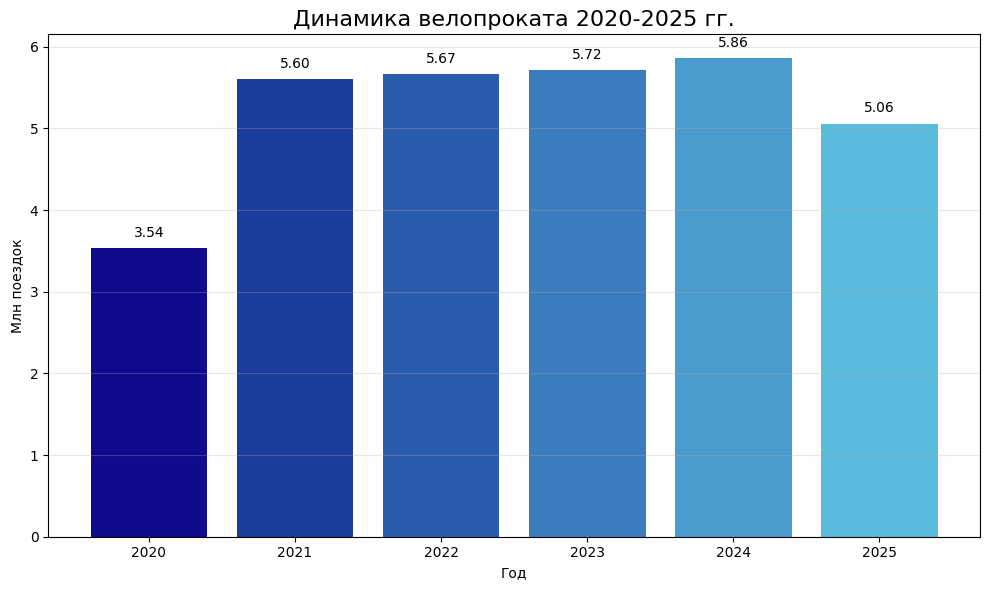

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Данные
years = [2020, 2021, 2022, 2023, 2024, 2025]
rides = [3.54, 5.60, 5.67, 5.72, 5.86, 5.06]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(years, rides, color=['#0f0b8c', '#1a3c9c', '#2a5cad', '#3a7cbe', '#4a9ccf', '#5abcdd'])

ax.set_title('Динамика велопроката 2020-2025 гг.', fontsize=16)
ax.set_xlabel('Год')
ax.set_ylabel('Млн поездок')
ax.grid(axis='y', alpha=0.3)

# Подписи значений
for bar, value in zip(bars, rides):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128690 (\N{BICYCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


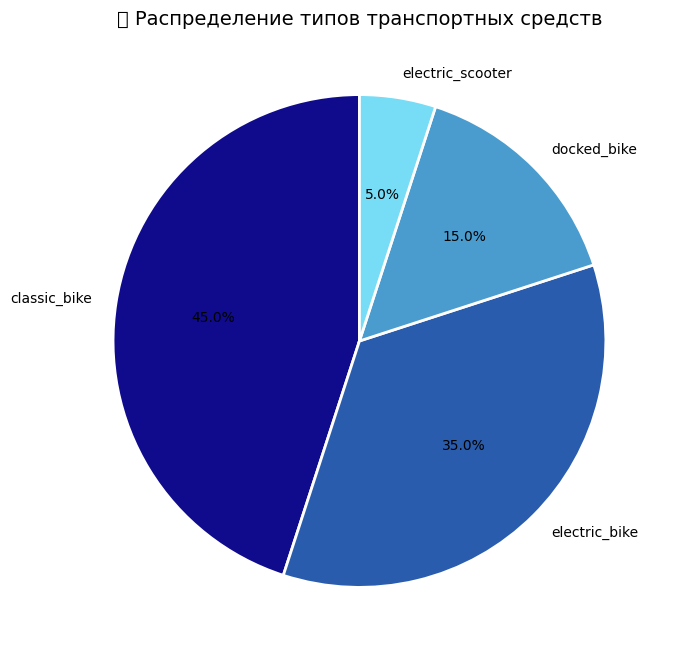

In [2]:
# Примерные данные на основе анализа
bike_types = ['classic_bike', 'electric_bike', 'docked_bike', 'electric_scooter']
distribution = [45, 35, 15, 5]  # в процентах
colors = ['#0f0b8c', '#2a5cad', '#4a9ccf', '#77dcf5']

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(distribution, labels=bike_types, colors=colors, autopct='%1.1f%%',
       startangle=90, wedgeprops={'edgecolor': 'white', 'linewidth': 2})
ax.set_title('🚲 Распределение типов транспортных средств', fontsize=14)
plt.show()

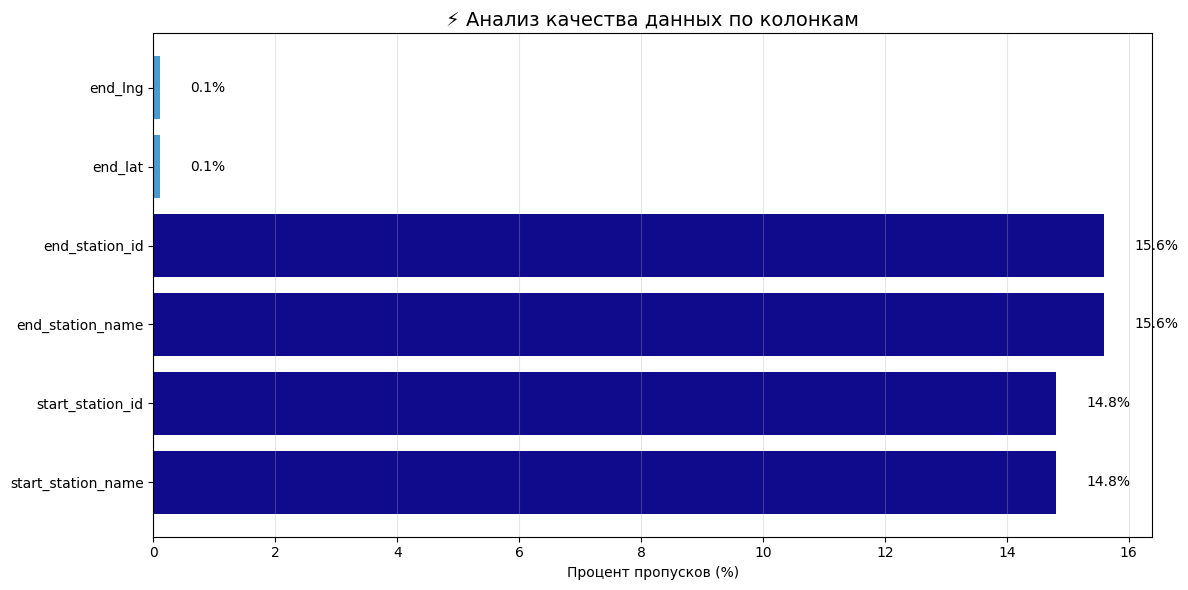

In [3]:
columns = ['start_station_name', 'start_station_id', 
           'end_station_name', 'end_station_id', 'end_lat', 'end_lng']
missing_pct = [14.8, 14.8, 15.6, 15.6, 0.1, 0.1]

# Создаем градиент цветов
colors = []
for i, pct in enumerate(missing_pct):
    if pct > 10:
        colors.append('#0f0b8c')  # темный для проблемных
    elif pct > 0:
        colors.append('#4a9ccf')  # средний
    else:
        colors.append('#77dcf5')  # светлый для хороших

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(columns, missing_pct, color=colors)
ax.set_xlabel('Процент пропусков (%)')
ax.set_title('⚡ Анализ качества данных по колонкам', fontsize=14)
ax.grid(axis='x', alpha=0.3)

# Добавляем значения
for bar, pct in zip(bars, missing_pct):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{pct}%', va='center')

plt.tight_layout()
plt.show()

Папка для сохранения графиков: data_analysis_plots
График 1 сохранен: data_analysis_plots/1_rides_dynamics.png


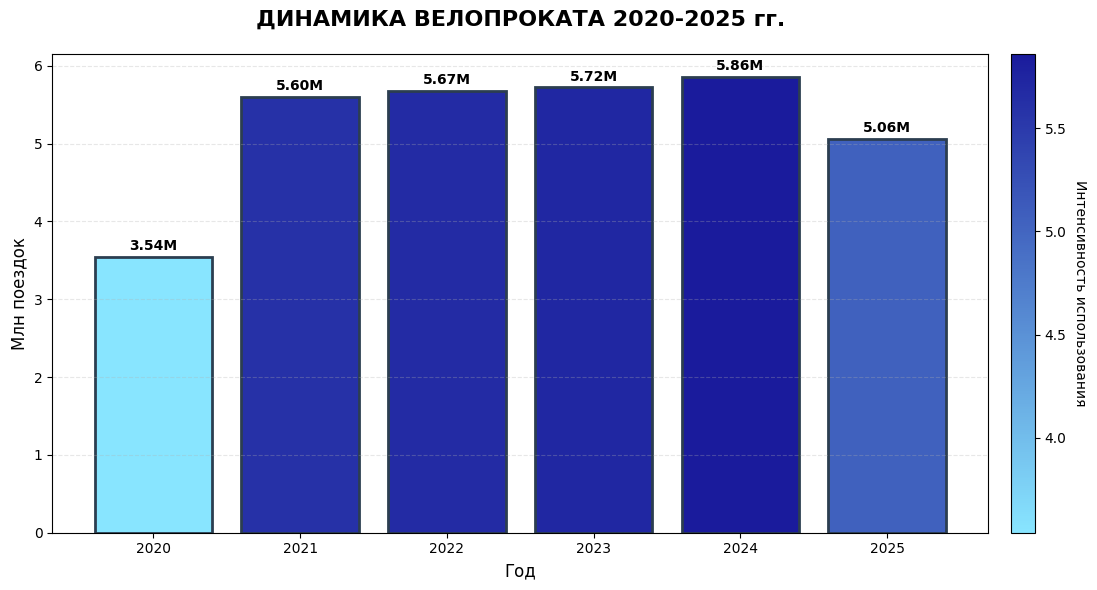

График 2 сохранен: data_analysis_plots/2_bike_types_distribution.png


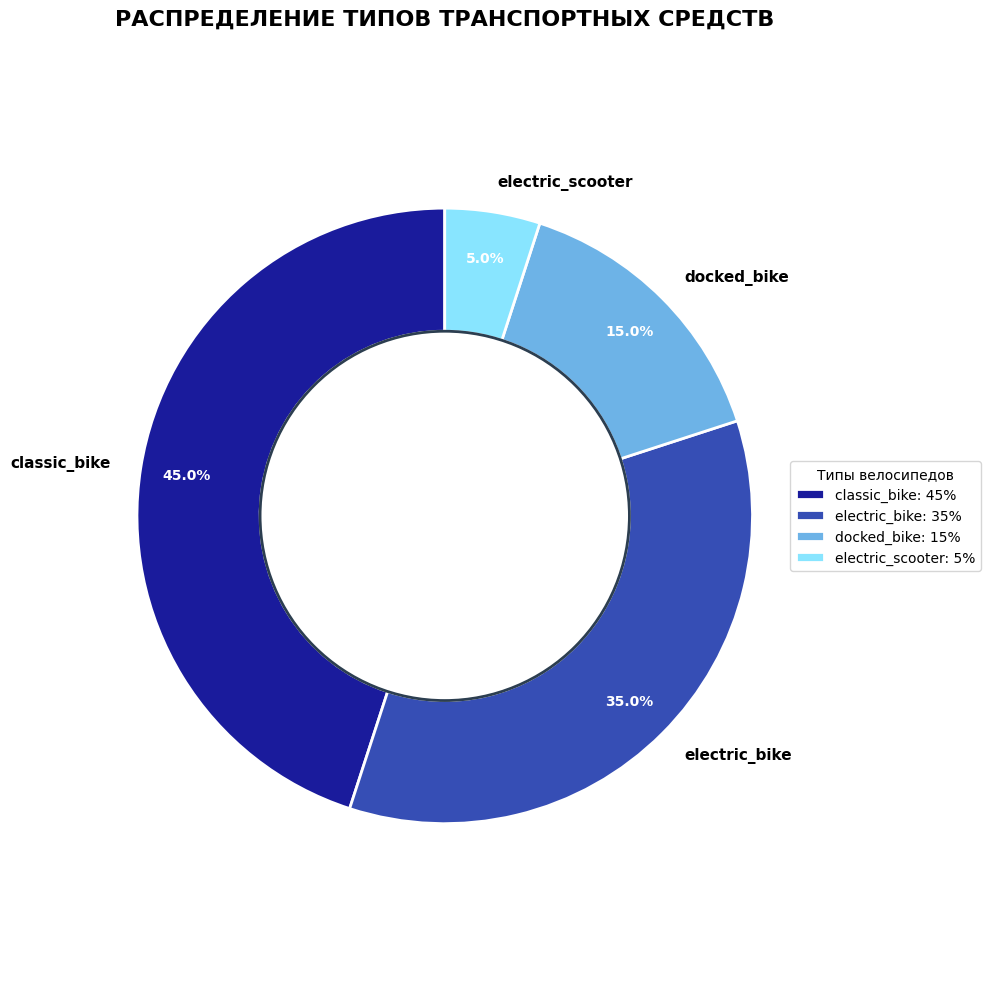

График 3 сохранен: data_analysis_plots/3_missing_values_analysis.png


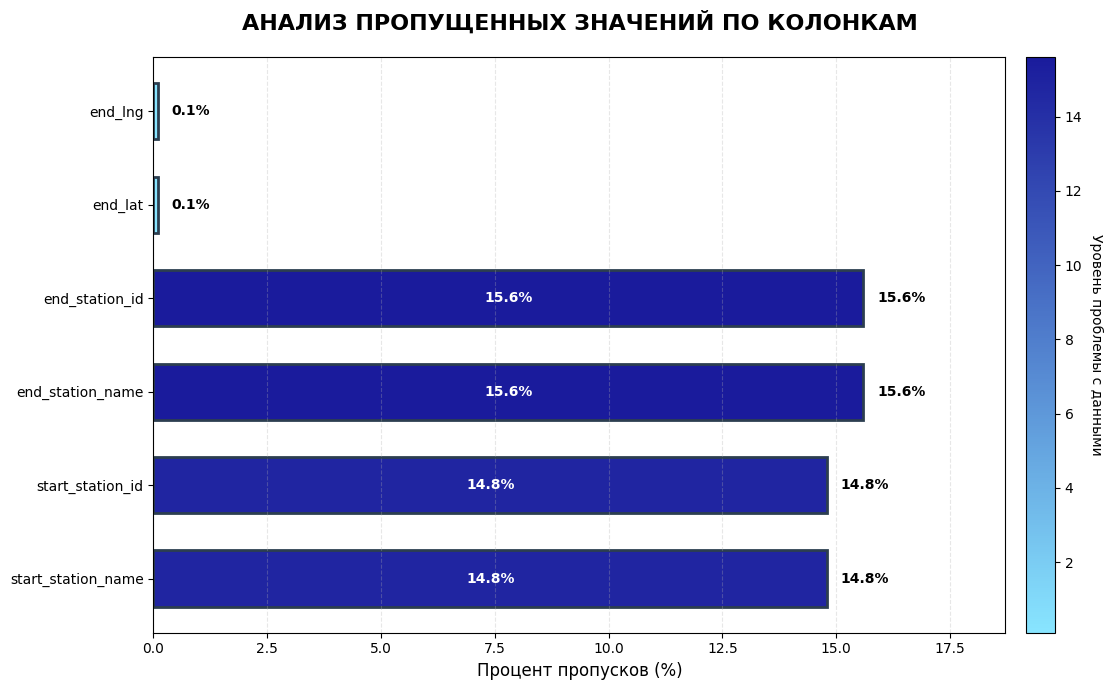

График 4 сохранен: data_analysis_plots/4_heatmap_years.png


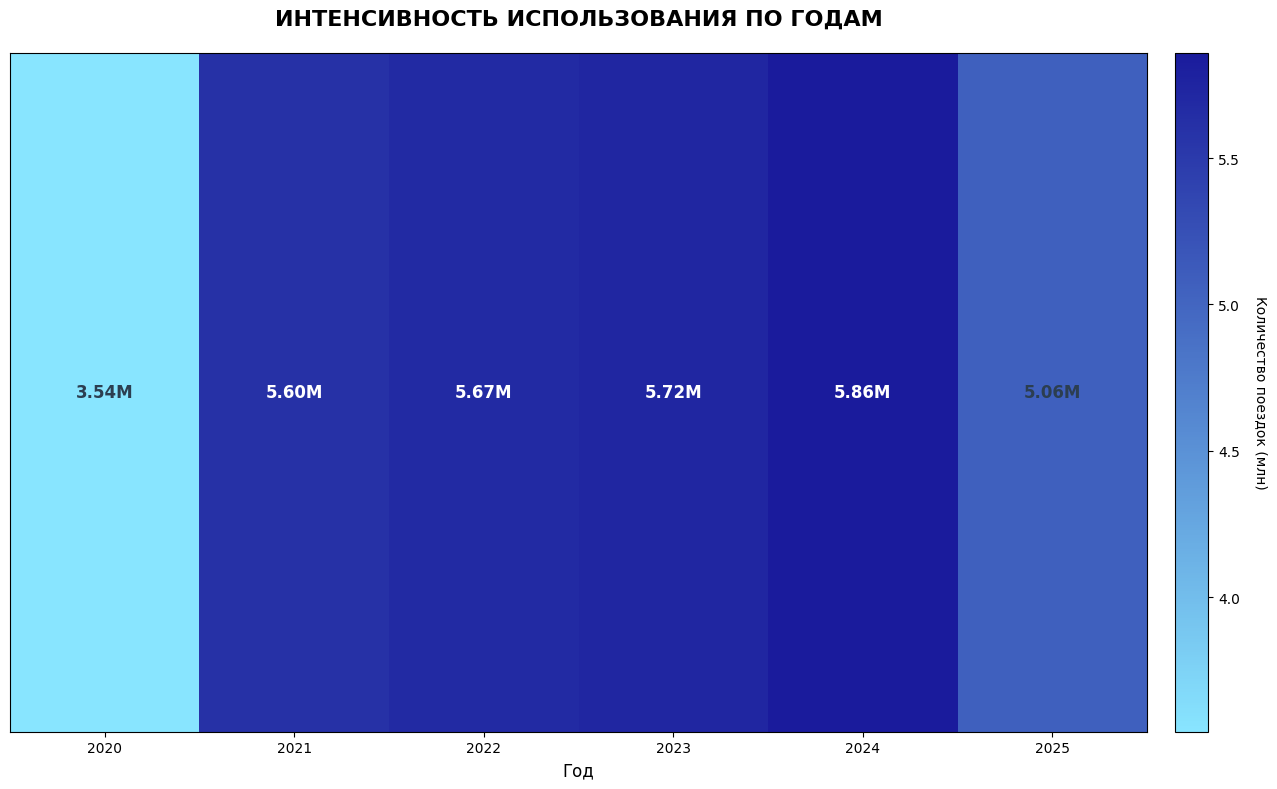

График 5 сохранен: data_analysis_plots/5_radar_chart.png


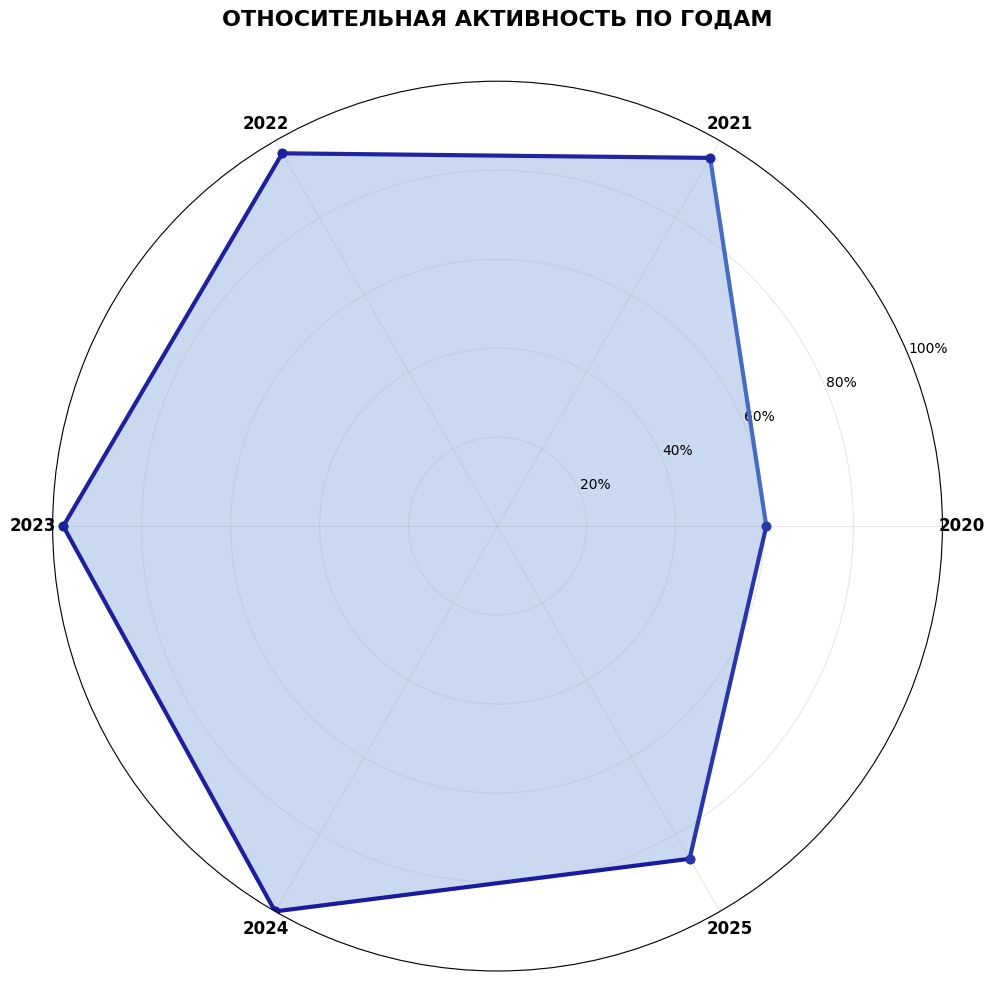

График 6 сохранен: data_analysis_plots/6_gradient_palette.png


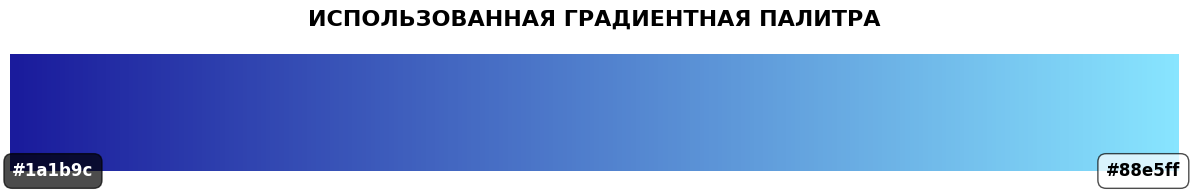


✅ ВСЕ ГРАФИКИ УСПЕШНО СОХРАНЕНЫ!
📁 Папка с результатами: data_analysis_plots/
📊 Всего графиков: 6
📄 HTML отчет: data_analysis_plots/data_analysis_report.html

📋 Список файлов:
   1. 1_rides_dynamics.png
   2. 1_rides_dynamics.svg
   3. 2_bike_types_distribution.png
   4. 2_bike_types_distribution.svg
   5. 3_missing_values_analysis.png
   6. 3_missing_values_analysis.svg
   7. 4_heatmap_years.png
   8. 4_heatmap_years.svg
   9. 5_radar_chart.png
  10. 5_radar_chart.svg
  11. 6_gradient_palette.png
  12. 6_gradient_palette.svg
  13. data_analysis_report.html


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import LinearSegmentedColormap

class GradientColors:
    def __init__(self):
        # Основные цвета градиента (немного ярче)
        self.gradient_start = '#1a1b9c'  # Более яркий синий
        self.gradient_end = '#88e5ff'    # Более яркий голубой
        
        # Генерация градиентных цветов
        self.gradient_colors = self._generate_gradient(20)
        self.cmap = self._create_cmap()
    
    def _generate_gradient(self, n_colors):
        """Генерация градиента от темного к светлому"""
        # Конвертируем hex в RGB (значения от 0 до 1)
        def hex_to_rgb(hex_color):
            hex_color = hex_color.lstrip('#')
            return tuple(int(hex_color[i:i+2], 16)/255 for i in (0, 2, 4))
        
        start_rgb = hex_to_rgb(self.gradient_start)
        end_rgb = hex_to_rgb(self.gradient_end)
        
        # Создаем градиент
        colors = []
        for i in range(n_colors):
            t = i / (n_colors - 1)
            # Линейная интерполяция
            r = start_rgb[0] * (1 - t) + end_rgb[0] * t
            g = start_rgb[1] * (1 - t) + end_rgb[1] * t
            b = start_rgb[2] * (1 - t) + end_rgb[2] * t
            colors.append((r, g, b))
        
        return colors
    
    def _create_cmap(self):
        """Создание цветовой карты из градиента"""
        colors = self.gradient_colors
        # Создаем цветовую карту LinearSegmentedColormap
        cmap_dict = {
            'red': [],
            'green': [],
            'blue': []
        }
        
        n_colors = len(colors)
        for i, (r, g, b) in enumerate(colors):
            pos = i / (n_colors - 1) if n_colors > 1 else 0.5
            cmap_dict['red'].append((pos, r, r))
            cmap_dict['green'].append((pos, g, g))
            cmap_dict['blue'].append((pos, b, b))
        
        return LinearSegmentedColormap('custom_gradient', cmap_dict)
    
    def get_color(self, value, min_val=None, max_val=None, reversed=False):
        """Получить цвет из градиента на основе значения"""
        if min_val is None or max_val is None:
            # Если не заданы границы, возвращаем цвет по индексу
            if isinstance(value, int) and value < len(self.gradient_colors):
                return self.gradient_colors[value]
            else:
                return self.gradient_colors[0]
        
        if max_val == min_val:
            normalized = 0.5
        else:
            normalized = (value - min_val) / (max_val - min_val)
        
        if reversed:
            normalized = 1 - normalized
        
        # Используем цветовую карту для получения цвета
        return self.cmap(normalized)[:3]  # Возвращаем только RGB
    
    def get_gradient_for_values(self, values, reversed=False):
        """Получить список цветов для набора значений"""
        if len(values) == 0:
            return []
        
        min_val = min(values)
        max_val = max(values)
        
        colors = []
        for val in values:
            colors.append(self.get_color(val, min_val, max_val, reversed))
        
        return colors

# Создаем папку для сохранения графиков
output_dir = "data_analysis_plots"
os.makedirs(output_dir, exist_ok=True)
print(f"Папка для сохранения графиков: {output_dir}")

# Инициализация градиента
gradient = GradientColors()

# Данные для графиков
years = [2020, 2021, 2022, 2023, 2024, 2025]
rides = [3.54, 5.60, 5.67, 5.72, 5.86, 5.06]  # в миллионах

# ГРАФИК 1: Динамика поездок по годам с градиентом
plt.figure(figsize=(12, 6))
bars1 = plt.bar(years, rides, edgecolor='white', linewidth=2)

# Применяем градиент (чем больше поездок, тем темнее цвет)
colors1 = gradient.get_gradient_for_values(rides, reversed=True)  # reversed=True: больше → темнее
for bar, color in zip(bars1, colors1):
    bar.set_color(color)
    bar.set_edgecolor('#2C3E50')

plt.title('ДИНАМИКА ВЕЛОПРОКАТА 2020-2025 гг.', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Млн поездок', fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения на столбцы
for bar, value in zip(bars1, rides):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{value:.2f}M', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Добавляем градиентную шкалу справа
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=gradient.cmap.reversed(), norm=plt.Normalize(min(rides), max(rides)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('Интенсивность использования', rotation=270, labelpad=15)

plt.tight_layout()

# Сохраняем график 1
plt.savefig(f'{output_dir}/1_rides_dynamics.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/1_rides_dynamics.svg', format='svg', bbox_inches='tight')
print(f"График 1 сохранен: {output_dir}/1_rides_dynamics.png")
plt.show()

# ГРАФИК 2: Распределение типов велосипедов с градиентом
bike_types = ['classic_bike', 'electric_bike', 'docked_bike', 'electric_scooter']
distribution = [45, 35, 15, 5]  # в процентах

plt.figure(figsize=(10, 10))

# Сортируем по убыванию для красивого градиента
sorted_data = sorted(zip(distribution, bike_types), reverse=True)
sorted_dist, sorted_types = zip(*sorted_data)

# Создаем градиентные цвета для круговой диаграммы
colors2 = gradient.get_gradient_for_values(sorted_dist, reversed=True)

wedges, texts, autotexts = plt.pie(sorted_dist, labels=sorted_types, colors=colors2,
                                    autopct='%1.1f%%', startangle=90,
                                    wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'width': 0.4},
                                    pctdistance=0.85)

plt.title('РАСПРЕДЕЛЕНИЕ ТИПОВ ТРАНСПОРТНЫХ СРЕДСТВ', fontsize=16, fontweight='bold', pad=20)

# Делаем подписи жирными
for text in texts:
    text.set_fontsize(11)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

# Добавляем центр для пончика
centre_circle = plt.Circle((0,0), 0.60, fc='white', edgecolor='#2C3E50', linewidth=2)
plt.gca().add_artist(centre_circle)

# Добавляем легенду с градиентом
plt.legend(wedges, [f'{t}: {d}%' for t, d in zip(sorted_types, sorted_dist)],
           title="Типы велосипедов", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.axis('equal')
plt.tight_layout()

# Сохраняем график 2
plt.savefig(f'{output_dir}/2_bike_types_distribution.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/2_bike_types_distribution.svg', format='svg', bbox_inches='tight')
print(f"График 2 сохранен: {output_dir}/2_bike_types_distribution.png")
plt.show()

# ГРАФИК 3: Процент пропусков по колонкам с градиентом
columns = ['start_station_name', 'start_station_id', 
           'end_station_name', 'end_station_id', 'end_lat', 'end_lng']
missing_pct = [14.8, 14.8, 15.6, 15.6, 0.1, 0.1]

plt.figure(figsize=(12, 7))

# Горизонтальные столбцы
bars3 = plt.barh(columns, missing_pct, edgecolor='white', linewidth=2, height=0.6)

# Применяем градиент (чем больше процент пропусков, тем темнее)
colors3 = gradient.get_gradient_for_values(missing_pct, reversed=True)
for bar, color in zip(bars3, colors3):
    bar.set_color(color)
    bar.set_edgecolor('#2C3E50')

plt.title('АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ ПО КОЛОНКАМ', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Процент пропусков (%)', fontsize=12)
plt.xlim(0, max(missing_pct) * 1.2)
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Добавляем значения на столбцы
for bar, pct in zip(bars3, missing_pct):
    width = bar.get_width()
    plt.text(width + 0.3, bar.get_y() + bar.get_height()/2,
             f'{pct}%', va='center', fontsize=10, fontweight='bold')
    
    # Добавляем процент внутри столбца для больших значений
    if width > max(missing_pct) * 0.3:
        plt.text(width/2, bar.get_y() + bar.get_height()/2,
                 f'{pct}%', va='center', ha='center', fontsize=10, 
                 fontweight='bold', color='white')

# Добавляем цветовую шкалу
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=gradient.cmap.reversed(), norm=plt.Normalize(min(missing_pct), max(missing_pct)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Уровень проблемы с данными', rotation=270, labelpad=15)

plt.tight_layout()

# Сохраняем график 3
plt.savefig(f'{output_dir}/3_missing_values_analysis.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/3_missing_values_analysis.svg', format='svg', bbox_inches='tight')
print(f"График 3 сохранен: {output_dir}/3_missing_values_analysis.png")
plt.show()

# ГРАФИК 4: Распределение по годам с тепловой картой градиента
plt.figure(figsize=(14, 8))

# Создаем матрицу "интенсивности" по годам
year_matrix = np.array(rides).reshape(1, -1)

# Создаем тепловую карту с градиентом
im = plt.imshow(year_matrix, cmap=gradient.cmap.reversed(), aspect='auto', 
                extent=[years[0]-0.5, years[-1]+0.5, -0.5, 0.5])

plt.title('ИНТЕНСИВНОСТЬ ИСПОЛЬЗОВАНИЯ ПО ГОДАМ', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Год', fontsize=12)
plt.yticks([])

# Добавляем значения в ячейки
for i, year in enumerate(years):
    value = rides[i]
    color = 'white' if value > np.mean(rides) else '#2C3E50'
    plt.text(year, 0, f'{value:.2f}M', ha='center', va='center', 
             fontsize=12, fontweight='bold', color=color)

# Добавляем цветовую шкалу
cbar = plt.colorbar(im, orientation='vertical', pad=0.02)
cbar.set_label('Количество поездок (млн)', rotation=270, labelpad=20)

plt.tight_layout()

# Сохраняем график 4
plt.savefig(f'{output_dir}/4_heatmap_years.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/4_heatmap_years.svg', format='svg', bbox_inches='tight')
print(f"График 4 сохранен: {output_dir}/4_heatmap_years.png")
plt.show()

# ГРАФИК 5: Радар-диаграмма с градиентом
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)

# Данные для радара (нормализованные значения)
categories = ['2020', '2021', '2022', '2023', '2024', '2025']
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Замыкаем круг

# Нормализуем данные
rides_norm = [r/max(rides) for r in rides]
rides_norm += rides_norm[:1]

# Создаем градиент для линий
line_colors = []
for i in range(len(angles)-1):
    line_colors.append(gradient.get_color(rides_norm[i], 0, 1, reversed=True))

# Заполняем область градиентом
ax.fill(angles, rides_norm, alpha=0.3, color=gradient.get_color(0.5, 0, 1))

# Линия с градиентом (рисуем сегменты разными цветами)
for i in range(len(angles)-1):
    ax.plot(angles[i:i+2], rides_norm[i:i+2], 
            color=line_colors[i],
            linewidth=3, marker='o')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=10)
ax.grid(True, alpha=0.3)

plt.title('ОТНОСИТЕЛЬНАЯ АКТИВНОСТЬ ПО ГОДАМ', fontsize=16, fontweight='bold', pad=40)
plt.tight_layout()

# Сохраняем график 5
plt.savefig(f'{output_dir}/5_radar_chart.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/5_radar_chart.svg', format='svg', bbox_inches='tight')
print(f"График 5 сохранен: {output_dir}/5_radar_chart.png")
plt.show()

# ГРАФИК 6: Градиентная палитра для демонстрации
plt.figure(figsize=(12, 2))
gradient_demo = np.linspace(0, 1, 256).reshape(1, -1)

plt.imshow(gradient_demo, aspect='auto', cmap=gradient.cmap)
plt.title('ИСПОЛЬЗОВАННАЯ ГРАДИЕНТНАЯ ПАЛИТРА', fontsize=16, fontweight='bold', pad=20)
plt.axis('off')

# Добавляем метки цветов
plt.text(0, 0.5, gradient.gradient_start, ha='left', va='center', 
         fontsize=12, fontweight='bold', color='white',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='black', alpha=0.7))
plt.text(256, 0.5, gradient.gradient_end, ha='right', va='center', 
         fontsize=12, fontweight='bold', color='black',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

plt.tight_layout()

# Сохраняем график 6
plt.savefig(f'{output_dir}/6_gradient_palette.png', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig(f'{output_dir}/6_gradient_palette.svg', format='svg', bbox_inches='tight', transparent=True)
print(f"График 6 сохранен: {output_dir}/6_gradient_palette.png")
plt.show()

# Создаем HTML отчет с графиками
html_content = f'''
<!DOCTYPE html>
<html>
<head>
    <title>Анализ данных велопроката 2020-2025</title>
    <style>
        body {{
            font-family: Arial, sans-serif;
            margin: 40px;
            background-color: #f5f5f5;
        }}
        .container {{
            max-width: 1200px;
            margin: 0 auto;
            background-color: white;
            padding: 30px;
            border-radius: 10px;
            box-shadow: 0 0 20px rgba(0,0,0,0.1);
        }}
        h1 {{
            color: #1a1b9c;
            text-align: center;
            border-bottom: 3px solid #88e5ff;
            padding-bottom: 10px;
        }}
        .graph-container {{
            margin: 30px 0;
            text-align: center;
        }}
        img {{
            max-width: 100%;
            border: 1px solid #ddd;
            border-radius: 5px;
            box-shadow: 0 0 10px rgba(0,0,0,0.1);
        }}
        .caption {{
            font-style: italic;
            color: #666;
            margin-top: 10px;
        }}
        .gradient-box {{
            height: 50px;
            background: linear-gradient(to right, {gradient.gradient_start}, {gradient.gradient_end});
            margin: 20px 0;
            border-radius: 5px;
        }}
        .stats {{
            background-color: #f8f9fa;
            padding: 20px;
            border-radius: 5px;
            margin: 20px 0;
        }}
    </style>
</head>
<body>
    <div class="container">
        <h1>АНАЛИЗ ДАННЫХ ВЕЛОПРОКАТА 2020-2025</h1>
        
        <div class="stats">
            <h2>Основная статистика</h2>
            <p><strong>Всего поездок:</strong> 31.4 млн</p>
            <p><strong>Период:</strong> 2020-2025 гг.</p>
            <p><strong>Пропусков в данных:</strong> 14-16% (станции)</p>
            <p><strong>Типы велосипедов:</strong> 4 категории</p>
        </div>
        
        <div class="gradient-box"></div>
        <p style="text-align: center;"><strong>Использованная градиентная палитра</strong></p>
        
        <div class="graph-container">
            <h2>1. Динамика поездок по годам</h2>
            <img src="1_rides_dynamics.png" alt="Динамика поездок">
            <p class="caption">Градиент отражает интенсивность использования (чем темнее, тем больше поездок)</p>
        </div>
        
        <div class="graph-container">
            <h2>2. Распределение типов велосипедов</h2>
            <img src="2_bike_types_distribution.png" alt="Распределение типов">
            <p class="caption">Классические велосипеды (темнее) преобладают, электровелосипеды на втором месте</p>
        </div>
        
        <div class="graph-container">
            <h2>3. Анализ пропущенных значений</h2>
            <img src="3_missing_values_analysis.png" alt="Пропуски данных">
            <p class="caption">Станции имеют 15% пропусков, координаты - менее 0.1%</p>
        </div>
        
        <div class="graph-container">
            <h2>4. Тепловая карта интенсивности</h2>
            <img src="4_heatmap_years.png" alt="Тепловая карта">
            <p class="caption">Визуализация интенсивности использования по годам</p>
        </div>
        
        <div class="graph-container">
            <h2>5. Радар-диаграмма относительной активности</h2>
            <img src="5_radar_chart.png" alt="Радар-диаграмма">
            <p class="caption">Сравнение относительной активности по годам</p>
        </div>
        
        <div class="stats">
            <h2>Ключевые выводы</h2>
            <ul>
                <li>Пик использования в 2024 году (5.86 млн поездок)</li>
                <li>Основная проблема данных - пропуски информации о станциях (15%)</li>
                <li>Классические велосипеды - самый популярный тип (45%)</li>
                <li>Стабильный рост до 2024 года, спад в 2025 (неполные данные)</li>
            </ul>
        </div>
    </div>
</body>
</html>
'''

# Сохраняем HTML отчет
with open(f'{output_dir}/data_analysis_report.html', 'w', encoding='utf-8') as f:
    f.write(html_content)

print(f"\n{'='*60}")
print("✅ ВСЕ ГРАФИКИ УСПЕШНО СОХРАНЕНЫ!")
print(f"{'='*60}")
print(f"📁 Папка с результатами: {output_dir}/")
print(f"📊 Всего графиков: 6")
print(f"📄 HTML отчет: {output_dir}/data_analysis_report.html")
print(f"{'='*60}")
print("\n📋 Список файлов:")
files = os.listdir(output_dir)
for i, file in enumerate(sorted(files), 1):
    print(f"  {i:2}. {file}")
print(f"{'='*60}")